### imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.graphics.gofplots import qqplot

from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, FunctionTransformer, PowerTransformer,\
                                  Normalizer, PowerTransformer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer
#from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, \
                                    cross_val_predict, cross_validate, GridSearchCV, KFold

from pylab import rcParams

from tensorflow import keras

import warnings; 
warnings.simplefilter('ignore')

from IPython.display import display
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 999

plt.style.use('dark_background')

# Data Overview

Read training data and info

In [3]:
data_train = pd.read_csv('train.csv')
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3865 entries, 0 to 3864
Data columns (total 80 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   galactic year                                                                            3865 non-null   int64  
 1   galaxy                                                                                   3865 non-null   object 
 2   existence expectancy index                                                               3864 non-null   float64
 3   existence expectancy at birth                                                            3864 non-null   float64
 4   Gross income per capita                                                                  3837 non-null   float64
 5   Income Index                                                  

In [4]:
data_test = pd.read_csv('test.csv')

data_test['y'] = -1

#data_all = data_train.append(data_test, ignore_index=True)
data_all = pd.concat([data_train, data_test], keys=['train', 'test'])

In [4]:
data_all.loc['train'].sort_values('y').iloc[[1,2,100,1000,2000,-100,-2,-1]].transpose()

3807         3772  \
galactic year                                           1015056      1014049   
galaxy                                              Leo V Dwarf  Pegasus III   
existence expectancy index                                 0.83         0.72   
existence expectancy at birth                             74.88        59.10   
Gross income per capita                               27,288.28    42,261.92   
Income Index                                               0.72         1.00   
Expected years of education (galactic years)              11.20        11.16   
Mean years of education (galactic years)                   7.25         7.65   
Intergalactic Development Index (IDI)                      0.59         0.67   
Education Index                                            0.54         0.63   
Intergalactic Development Index (IDI), Rank              218.32       211.02   
Population using at least basic drinking-water ...        96.51        85.99   
Population using at least basic sanitation serv...       104.84       107.24   
Gross capital formation (% of GGP)                        57.41        35.93   
Population, total (millions)                             167.74       715.91   
Population, urban (%)                                     89.11       105.95   
Mortality rate, under-five (per 1,000 live births)        85.65       123.52   
Mortality rate, infant (per 1,000 live births)            76.81        89.70   
Old age dependency ratio (old age (65 and older...        15.99        12.42   
Population, ages 15–64 (millions)                        679.17       724.20   
Population, ages 65 and older (millions)                  41.63        49.04   
Life expectancy at birth, male (galactic years)           69.01        64.84   
Life expectancy at birth, female (galactic years)         70.95        63.69   
Population, under age 5 (millions)                       107.91        85.15   
Young age (0-14) dependency ratio (per 100 crea...        67.35        80.49   
Adolescent birth rate (births per 1,000 female ...        49.00       211.84   
Total unemployment rate (female to male ratio)             3.10         2.67   
Vulnerable employment (% of total employment)             89.40        76.09   
Unemployment, total (% of labour force)                   13.30        15.10   
Employment in agriculture (% of total employment)         66.35        58.06   
Labour force participation rate (% ages 15 and ...        70.63        75.49   
Labour force participation rate (% ages 15 and ...        70.97        78.55   
Employment in services (% of total employment)            63.25        55.93   
Labour force participation rate (% ages 15 and ...        82.24        70.73   
Employment to population ratio (% ages 15 and o...        66.65        62.63   
Jungle area (% of total land area)                        20.01        82.24   
Share of employment in nonagriculture, female (...        58.12        44.84   
Youth unemployment rate (female to male ratio)             2.68         2.01   
Unemployment, youth (% ages 15–24)                        36.73        35.52   
Mortality rate, female grown up (per 1,000 people)       360.20       396.51   
Mortality rate, male grown up (per 1,000 people)         389.76       412.01   
Infants lacking immunization, red hot disease (...        43.05        67.66   
Infants lacking immunization, Combination Vacci...        24.39        50.20   
Gross galactic product (GGP) per capita                     NaN    37,224.07   
Gross galactic product (GGP), total                         NaN     7,167.59   
Outer Galaxies direct investment, net inflows (...        19.30        13.94   
Exports and imports (% of GGP)                           133.77       111.36   
Share of seats in senate (% held by female)               27.32        25.03   
Natural resource depletion                                12.55        47.56   
Mean years of education, female (galactic years)           

### Корреляции

In [5]:
data_wrk = data_train.drop(['galactic year','galaxy'], axis=1)
corr = data_wrk.corrwith(data_wrk['y'])
corr_spearman = data_wrk.corrwith(data_wrk['y'], method='spearman')
corr_kendall = data_wrk.corrwith(data_wrk['y'], method='kendall')
#rcParams['figure.figsize'] = 18, 18
#top_features = corr.index[(abs(corr['y'])>0.5) & (abs(corr_spearman['y'])>0.5) & (abs(corr_kendall['y'])>0.5)]
#sns.heatmap(data_wrk[top_features].corr(), vmin=-1, vmax=1, cmap='RdBu_r', square=True, annot=True);
#plt.show()

cols_corr_desc = pd.DataFrame((corr, corr_kendall, corr_spearman)).transpose().drop('y')
cols_corr_desc

0     1     2
existence expectancy index                          0.55  0.51  0.71
existence expectancy at birth                       0.56  0.52  0.72
Gross income per capita                             0.51  0.40  0.56
Income Index                                        0.58  0.48  0.65
Expected years of education (galactic years)        0.58  0.46  0.64
Mean years of education (galactic years)            0.58  0.49  0.68
Intergalactic Development Index (IDI)               0.63  0.54  0.74
Education Index                                     0.61  0.50  0.69
Intergalactic Development Index (IDI), Rank        -0.68 -0.64 -0.82
Population using at least basic drinking-water ...  0.43  0.44  0.63
Population using at least basic sanitation serv...  0.48  0.47  0.66
Gross capital formation (% of GGP)                 -0.01  0.04  0.06
Population, total (millions)                       -0.06  0.02  0.03
Population, urban (%)                               0.48  0.36  0.51
Mortality rate, under-five (per 1,000 live births) -0.39 -0.40 -0.58
Mortality rate, infant (per 1,000 live births)     -0.43 -0.43 -0.61
Old age dependency ratio (old age (65 and older...  0.68  0.50  0.69
Population, ages 15–64 (millions)                  -0.07 -0.00 -0.00
Population, ages 65 and older (millions)           -0.05  0.01  0.01
Life expectancy at birth, male (galactic years)     0.54  0.44  0.62
Life expectancy at birth, female (galactic years)   0.52  0.49  0.68
Population, under age 5 (millions)                 -0.07 -0.02 -0.03
Young age (0-14) dependency ratio (per 100 crea... -0.53 -0.46 -0.65
Adolescent birth rate (births per 1,000 female ... -0.49 -0.43 -0.61
Total unemployment rate (female to male ratio)     -0.10 -0.07 -0.10
Vulnerable employment (% of total employment)      -0.50 -0.44 -0.62
Unemployment, total (% of labour force)            -0.03  0.06  0.10
Employment in agriculture (% of total employment)  -0.47 -0.40 -0.57
Labour force participation rate (% ages 15 and ... -0.05 -0.12 -0.18
Labour force participation rate (% ages 15 and ...  0.07 -0.05 -0.10
Employment in services (% of total employment)      0.49  0.38  0.54
Labour force participation rate (% ages 15 and ... -0.21 -0.19 -0.28
Employment to population ratio (% ages 15 and o... -0.04 -0.10 -0.16
Jungle area (% of total land area)                 -0.02 -0.01 -0.02
Share of employment in nonagriculture, female (...  0.21  0.11  0.16
Youth unemployment rate (female to male ratio)     -0.15 -0.08 -0.12
Unemployment, youth (% ages 15–24)                  0.00  0.09  0.14
Mortality rate, female grown up (per 1,000 people) -0.44 -0.45 -0.63
Mortality rate, male grown up (per 1,000 people)   -0.45 -0.36 -0.52
Infants lacking immunization, red hot disease (... -0.24 -0.20 -0.30
Infants lacking immunization, Combination Vacci... -0.25 -0.21 -0.31
Gross galactic product (GGP) per capita             0.58  0.42  0.58
Gross galactic product (GGP), total                -0.01  0.06  0.09
Outer Galaxies direct investment, net inflows (...  0.13  0.00  0.00
Exports and imports (% of GGP)                      0.26  0.10  0.14
Share of seats in senate (% held by female)         0.38  0.11  0.16
Natural resource depletion                         -0.22 -0.24 -0.35
Mean years of education, female (galactic years)    0.55  0.45  0.63
Mean years of education, male (galactic years)      0.57  0.45  0.64
Expected years of education, female (galactic y...  0.56  0.42  0.60
Expected years of education, male (galactic years)  0.57  0.41  0.58
Maternal mortality ratio (deaths per 100,000 li... -0.35 -0.39 -0.56
Renewable energy consumption (% of total final ... -0.23 -0.27 -0.40
Estimated gross galactic income per capita, male    0.52  0.42  0.58
Estimated gross galactic income per capita, female  0.67  0.41  0.57
Rural population with access to electricity (%)     0.44  0.43  0.62
Domestic credit provided by financial sector (%...  0.53  0.35  0.50
Population with at least some secondary educati...  0

In [118]:
corr_plot = data_train[cols_corr_desc.index[(abs(cols_corr_desc) > 0.7).any(axis=1)]].corr('spearman')

rcParams['figure.figsize'] =30, 30

g = sns.heatmap(corr_plot, vmin=-1, vmax=1, cmap='RdBu_r', square=True, annot=True)

In [53]:
def labels_wrap(label, lenght):
    xl = []
    while label:
        xl.append(label[:lenght])
        label = label[lenght:]
    return '\n'.join(xl)

#cols = cols_corr_desc.index[(abs(cols_corr_desc) > 0.7).any(axis=1)]
cols = notnan_columns + ['y']
corr_plot = data_train[cols].corr()

rcParams['figure.figsize'] =30, 30

g = sns.PairGrid(data_train[cols])
g = g.map_upper(sns.scatterplot)
g = g.map_lower(sns.kdeplot, colors="y")
g = g.map_diag(plt.hist, bins=30)

for ax in g.axes.flatten():
    # rotate x axis labels       
    ax.set_xlabel(labels_wrap(ax.get_xlabel(), 10), rotation = 0)
    # rotate y axis labels
    ax.set_ylabel(labels_wrap(ax.get_ylabel(), 10), rotation = 0)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')

#### Корреляции признаков между собой

In [7]:
features_corr = data_train.drop('y', axis=1).corr()
features_corr -= np.eye(features_corr.shape[0])
features_corr.loc[(features_corr > 0.9).any(axis=1), (features_corr > 0.9).any(axis=0)]

existence expectancy index  \
existence expectancy index                                                0.00   
existence expectancy at birth                                             0.91   
Population, total (millions)                                              0.01   
Mortality rate, under-five (per 1,000 live births)                       -0.84   
Mortality rate, infant (per 1,000 live births)                           -0.85   
Population, ages 15–64 (millions)                                         0.01   
Population, ages 65 and older (millions)                                  0.03   
Life expectancy at birth, female (galactic years)                         0.90   
Population, under age 5 (millions)                                       -0.01   
Intergalactic inbound tourists (thousands)                                0.04   

                                                    existence expectancy at birth  \
existence expectancy index                                                   0.91   
existence expectancy at birth                                                0.00   
Population, total (millions)                                                 0.02   
Mortality rate, under-five (per 1,000 live births)                          -0.83   
Mortality rate, infant (per 1,000 live births)                              -0.84   
Population, ages 15–64 (millions)                                            0.01   
Population, ages 65 and older (millions)                                     0.02   
Life expectancy at birth, female (galactic years)                            0.90   
Population, under age 5 (millions)                                          -0.01   
Intergalactic inbound tourists (thousands)                                   0.04   

                                                    Population, total (millions)  \
existence expectancy index                                                  0.01   
existence expectancy at birth                                               0.02   
Population, total (millions)                                                0.00   
Mortality rate, under-five (per 1,000 live births)                          0.03   
Mortality rate, infant (per 1,000 live births)                              0.02   
Population, ages 15–64 (millions)                                           0.92   
Population, ages 65 and older (millions)                                    0.91   
Life expectancy at birth, female (galactic years)                           0.02   
Population, under age 5 (millions)                                          0.91   
Intergalactic inbound tourists (thousands)                                  0.90   

                                                    Mortality rate, under-five (per 1,000 live births)  \
existence expectancy index                                                                      -0.84    
existence expectancy at birth                                                                   -0.83    
Population, total (millions)                                                                     0.03    
Mortality rate, under-five (per 1,000 live births)                                               0.00    
Mortality rate, infant (per 1,000 live births)                                                   0.91    
Population, ages 15–64 (millions)                                                                0.04    
Population, ages 65 and older (millions)                                                         0.02    
Life expectancy at birth, female (galactic years)                                               -0.85    
Population, under age 5 (millions)                                                               0.05    
Intergalactic inbound tourists (thousands)                                                       0.03    

                                                    Mortality rate, infant (per 1,000 live births)  \
existence expectanc

### Отрицательные значения

Gross income per capita  Population, total (millions)  \
count                 3,837.00                      1,271.00   
mean                 31,633.24                        891.29   
std                  18,736.38                        894.15   
min                    -126.91                       -160.44   
25%                  20,169.12                        599.65   
50%                  26,600.77                        774.11   
75%                  36,898.63                        952.23   
max                 151,072.68                      7,993.32   

       Population, ages 15–64 (millions)  \
count                           1,264.00   
mean                              578.33   
std                               571.04   
min                               -91.29   
25%                               393.56   
50%                               501.29   
75%                               614.06   
max                             5,542.81   

       Population, ages 65 and older (millions)  \
count                                  1,264.00   
mean                                      65.07   
std                                       63.14   
min                                      -23.66   
25%                                       43.45   
50%                                       56.85   
75%                                       69.75   
max                                      649.49   

       Population, under age 5 (millions)  \
count                            1,264.00   
mean                                89.53   
std                                 89.71   
min                                 -2.09   
25%                                 60.16   
50%                                 77.69   
75%                                 95.08   
max                                780.96   

       Employment in agriculture (% of total employment)  \
count                                           1,237.00   
mean                                               54.03   
std                                                25.16   
min                                                -0.68   
25%                                                34.15   
50%                                                49.54   
75%                                                71.63   
max                                               131.09   

       Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)  \
count                                           1,219.00                                 
mean                                               18.80                                 
std                                                11.51                                 
min                                                -1.32                                 
25%                                                11.91                                 
50%                                                15.34                                 
75%                                                21.36                                 
max                                                72.43                                 

       Gross galactic product (GGP), total  \
count                             1,202.00   
mean                              7,749.98   
std                               7,167.78   
min                                -933.22   
25%                               5,479.46   
50%                               7,130.47   
75%                               8,786.80   
max                             112,391.32   

       Outer Galaxies direct investment, net inflows (% of GGP)  \
count                                           1,169.00          
mean                                               18.34          
std                                                15.38          
min                                                -5.27          
25%                                                13.02         

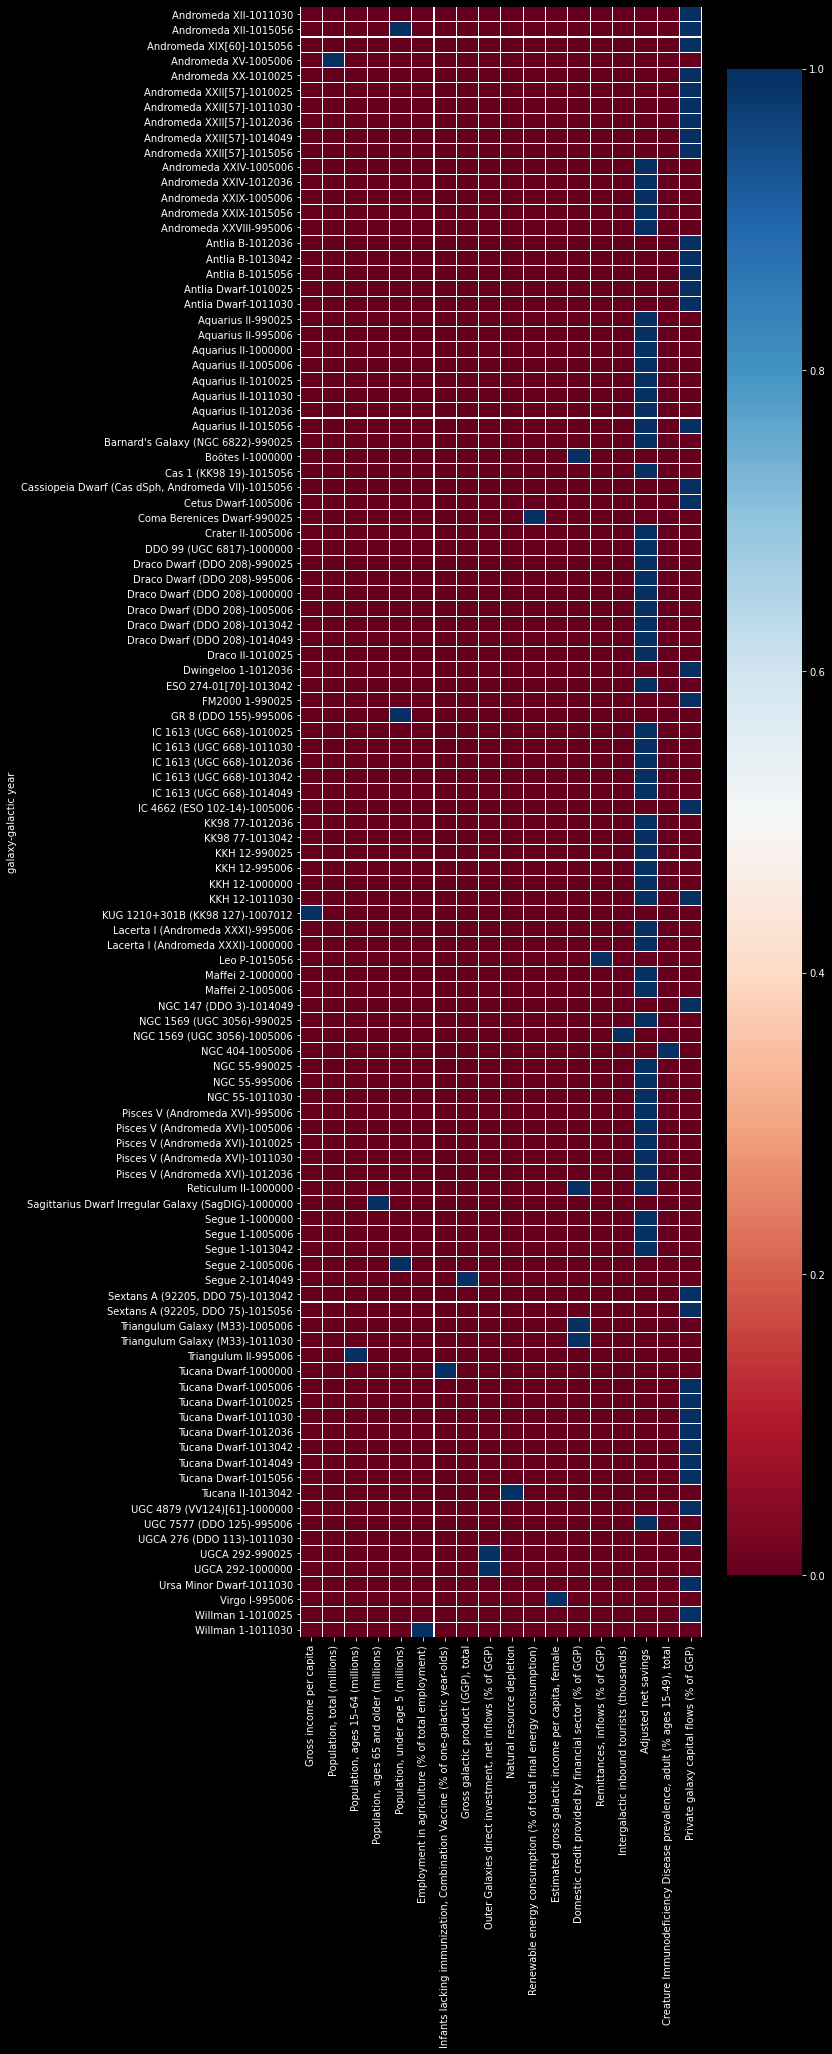

In [47]:
rcParams['figure.figsize'] = 9, 30
data_train_subzero_cols = [x for x in data_train.columns if \
                           (data_train[x].dtype in ['float64', 'int64'] and data_train[x].min() < 0)]
data_train_subzero = data_train[(data_train.drop('galaxy', axis=1) < 0).any(axis=1)][['galaxy', 'galactic year'] + data_train_subzero_cols]
sns.heatmap(data_train_subzero.set_index(['galaxy', 'galactic year']).sort_index() < 0, cmap="RdBu", linewidths=0.05)
display(data_train[data_train_subzero_cols].describe(include='all'))

In [6]:
data = data_test
l1 = data.iloc[:,2:].columns[(data.iloc[:,2:] < 0).any(axis=0)]
data = data_train
l2 = data.iloc[:,2:].columns[(data.iloc[:,2:] < 0).any(axis=0)]

drop_subzero_columns = set()
drop_subzero_columns.update({'Adjusted net savings ', 'Private galaxy capital flows (% of GGP)'})
drop_subzero_columns

{'Adjusted net savings ', 'Private galaxy capital flows (% of GGP)'}

Отрицательные значения:

### Fill NaN

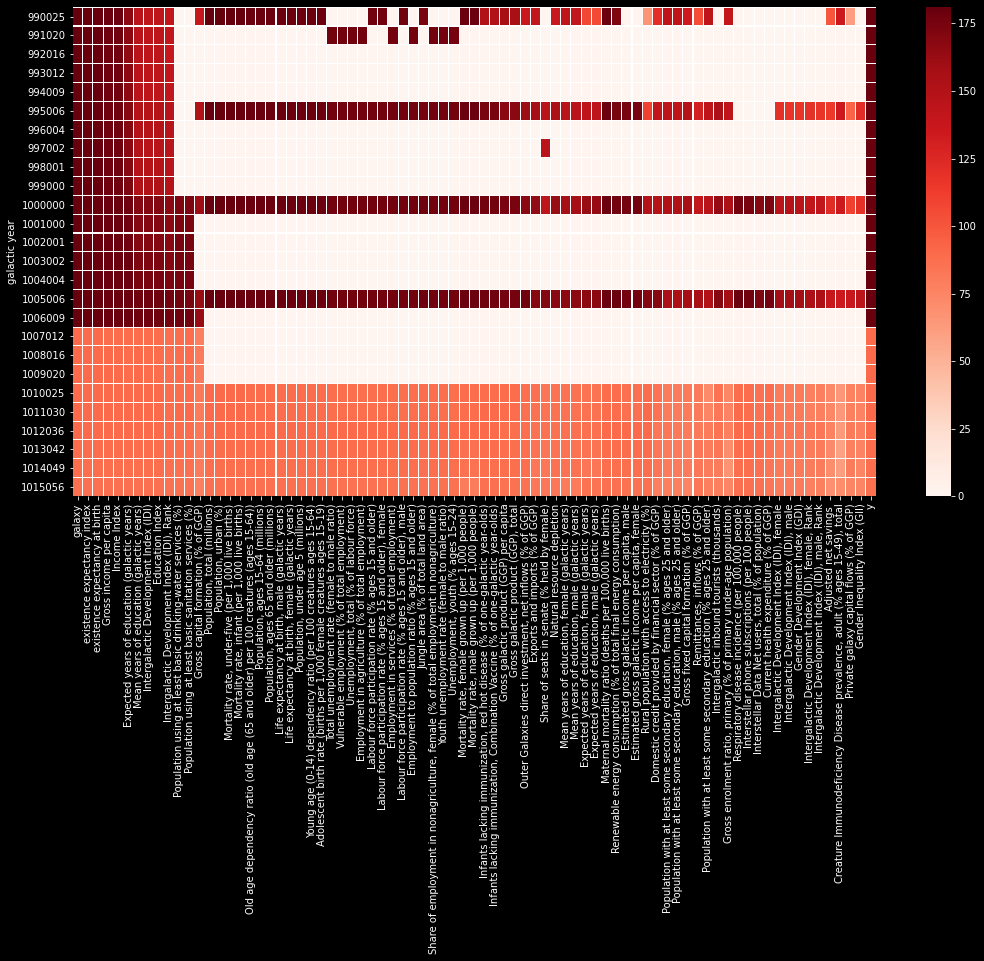

In [8]:
# Кол-во стран с незаполненными атрибутами по года
data = data_all.loc['train']
rcParams['figure.figsize'] = 18, 9

cols_nan = [x for x in data.columns if any((data[x] == data[x])) and x != 'galactic year']
sns.heatmap((data[['galactic year']].join(data[cols_nan] == data[cols_nan])).groupby('galactic year').sum(),
           cmap="Reds", linewidths=0.05);

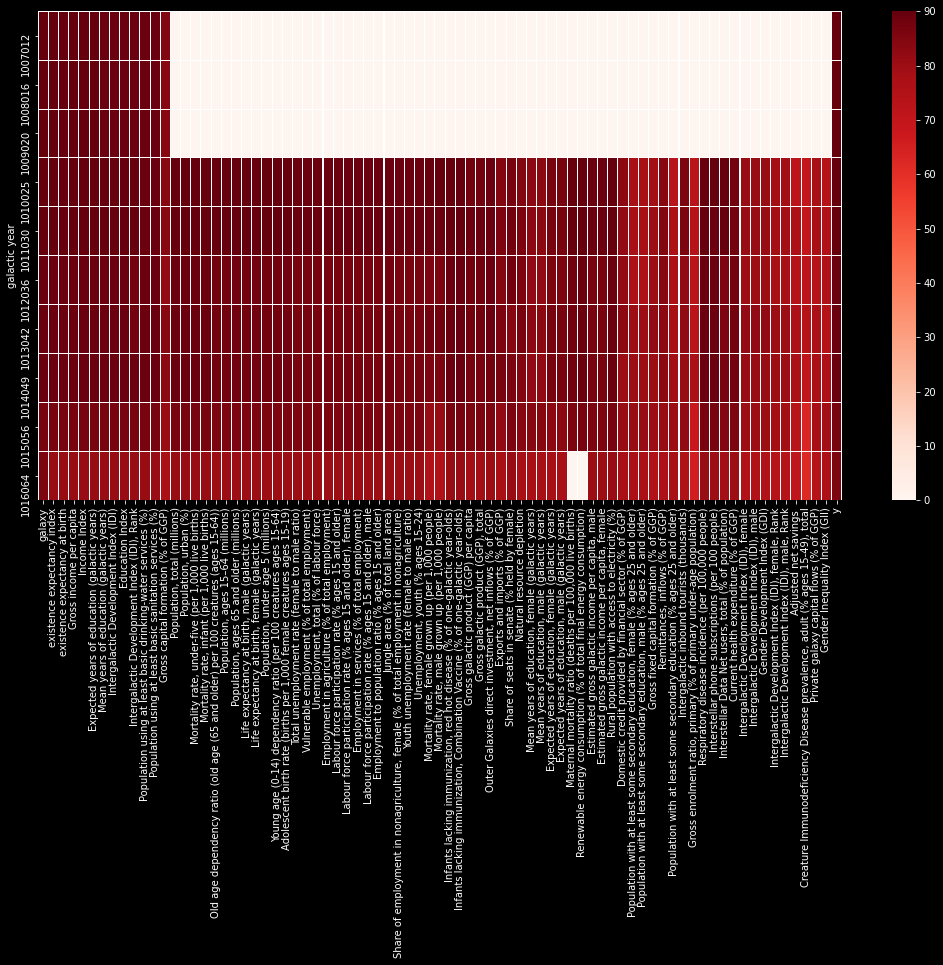

In [7]:
# Кол-во стран с незаполненными атрибутами по года
data = data_all.loc['test']
rcParams['figure.figsize'] = 18, 9

cols_nan = [x for x in data.columns if any((data[x] == data[x])) and x != 'galactic year']
sns.heatmap((data[['galactic year']].join(data[cols_nan] == data[cols_nan])).groupby('galactic year').sum(),
           cmap="Reds", linewidths=0.05);

Признаки, заполненные для всех периодов

In [34]:
notnan_columns = list(data_train.columns[(data_train.groupby('galactic year', as_index=False).count() > 5).all()])
notnan_columns.remove('galaxy')
notnan_columns.remove('y')
notnan_columns.remove('galactic year')
notnan_columns

['existence expectancy index',
 'existence expectancy at birth',
 'Gross income per capita',
 'Income Index',
 'Expected years of education (galactic years)',
 'Mean years of education (galactic years)',
 'Intergalactic Development Index (IDI)',
 'Education Index',
 'Intergalactic Development Index (IDI), Rank']

In [33]:
# Влияют ли NaN на 'y'
data_all.groupby('galactic year')['y'].agg(['min', 'mean', 'max'])
# как будто нет, вероятно для расчетов в gap-годы используются значения из предыдущих заполненных

min  mean   max
galactic year                  
990025         0.05  0.08  0.31
991020         0.05  0.08  0.32
992016         0.04  0.08  0.32
993012         0.04  0.08  0.32
994009         0.04  0.08  0.32
995006         0.04  0.08  0.33
996004         0.04  0.08  0.34
997002         0.04  0.08  0.34
998001         0.04  0.08  0.35
999000         0.04  0.08  0.35
1000000        0.04  0.08  0.35
1001000        0.04  0.08  0.37
1002001        0.04  0.08  0.38
1003002        0.04  0.08  0.38
1004004        0.04  0.08  0.38
1005006        0.04  0.08  0.38
1006009        0.03  0.08  0.37
1007012       -1.00 -0.46  0.37
1008016       -1.00 -0.46  0.37
1009020       -1.00 -0.46  0.37
1010025       -1.00 -0.46  0.37
1011030       -1.00 -0.46  0.55
1012036       -1.00 -0.45  0.53
1013042       -1.00 -0.45  0.68
1014049       -1.00 -0.46  0.68
1015056       -1.00 -0.46  0.53
1016064       -1.00 -1.00 -1.00

Периоды с незаполненными признаками заполняем методом ffill.

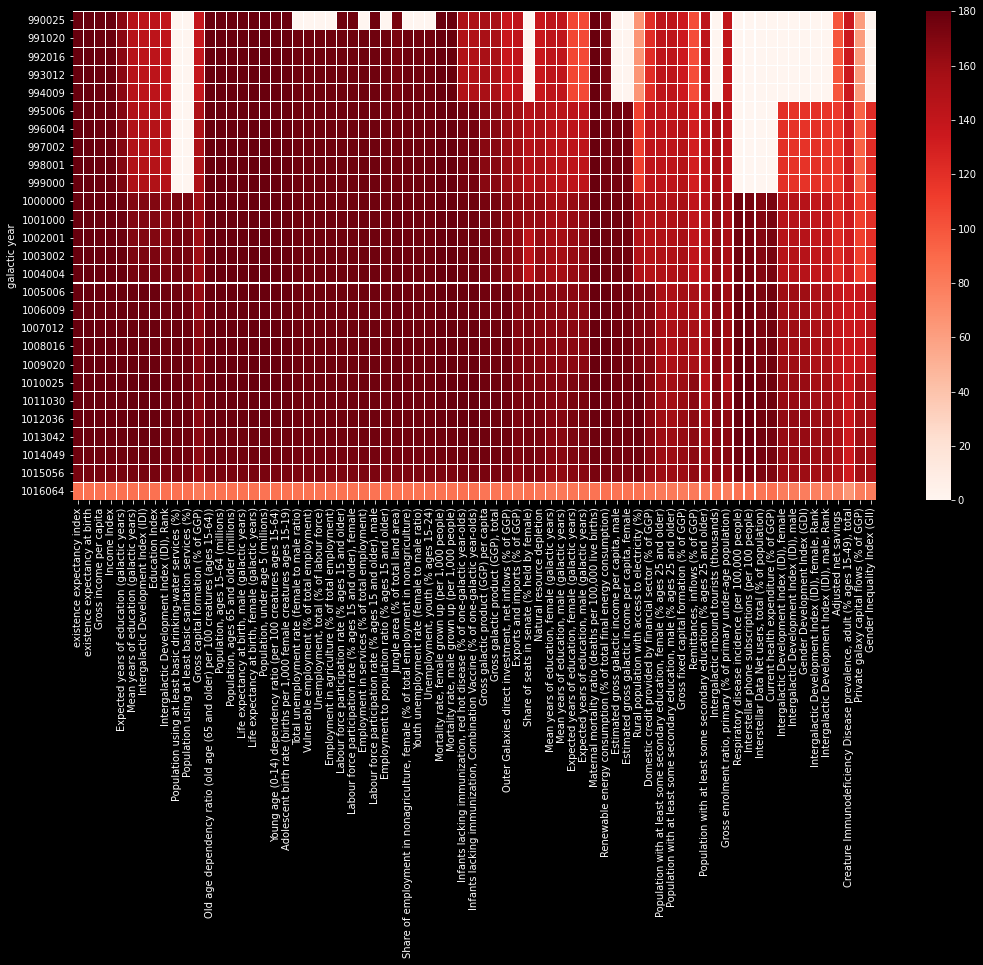

In [105]:
data_all = data_all.sort_values(['galaxy', 'galactic year']).groupby('galaxy', as_index=False).fillna(method='ffill', limit=4)
data = data_all

rcParams['figure.figsize'] = 18, 9

cols_nan = [x for x in data.columns if data[x].isnull().any() and x != 'galactic year']
sns.heatmap((data[['galactic year']].join(data[cols_nan].notna())).groupby('galactic year').sum(),
           cmap="Reds", linewidths=0.05);
plt.show()

### Распределение **y**

             y        y        y
count 3,865.00 3,865.00 3,865.00
mean      0.08    -0.54     0.20
std       0.06     0.11     0.03
min       0.01    -0.87     0.11
25%       0.05    -0.61     0.18
50%       0.06    -0.57     0.20
75%       0.09    -0.49     0.21
max       0.68    -0.08     0.30


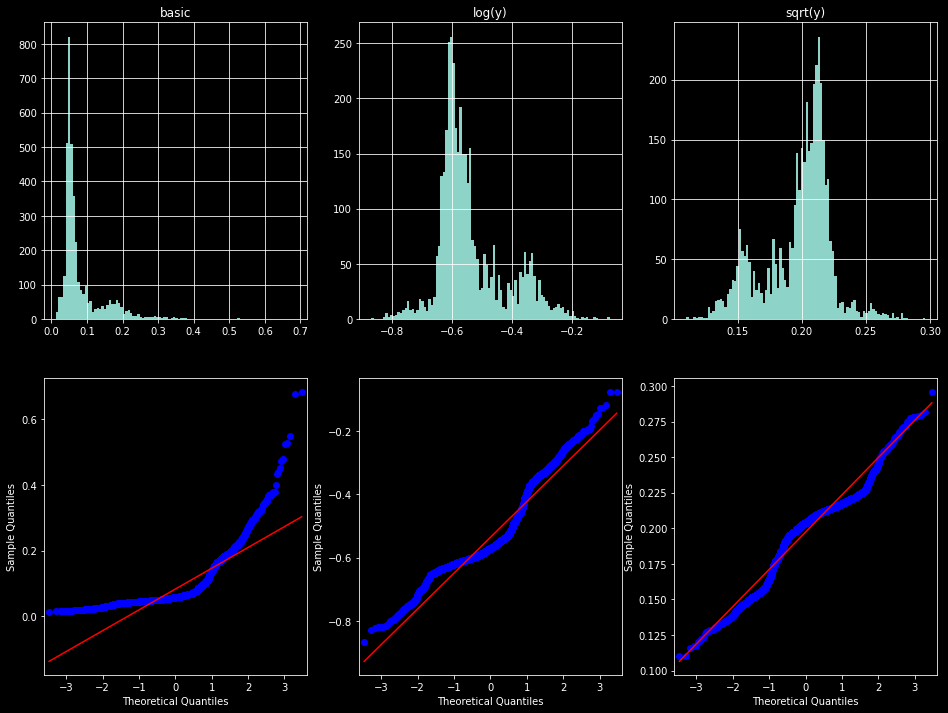

In [311]:
fig, ax = plt.subplots(2,3,figsize=(16,12))

desc_y = data_train['y'].describe()
ax[0,0].set_title('basic')
data_train['y'].hist(bins=100, ax=ax[0,0]);
qqplot(data_train['y'], ax=ax[1,0], line='s', fit=False);

log_y = np.log(data_train['y']) / 5
ax[0,1].set_title('log(y)')
log_y.hist(bins=100, ax=ax[0,1]);
qqplot(log_y, ax=ax[1,1], line='s')
desc_y = pd.concat([desc_y, log_y.describe()], axis=1)

root_y = data_train['y'] ** (-1/4) / 10
ax[0,2].set_title('sqrt(y)')
root_y.hist(bins=100, ax=ax[0,2]);
qqplot(root_y, ax=ax[1,2], line='s')
desc_y = pd.concat([desc_y, root_y.describe()], axis=1)
print(desc_y)

plt.show()

-0.5766501350892045


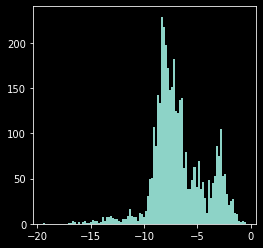

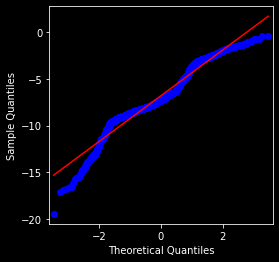

In [320]:
import scipy
data_boxcox, p = scipy.stats.boxcox(data_train['y'])
data_boxcox
rcParams['figure.figsize'] = 4, 4
plt.hist(data_boxcox, bins=100);
qqplot(data_boxcox, line='s');
print(p)

Значения **y** по годам и галактикам:

In [59]:
data_train.groupby('galactic year')['y'].agg(['min', 'mean', 'max', 'std'])

min  mean  max  std
galactic year                     
990025        0.05  0.08 0.31 0.05
991020        0.05  0.08 0.32 0.05
992016        0.04  0.08 0.32 0.05
993012        0.04  0.08 0.32 0.05
994009        0.04  0.08 0.32 0.05
995006        0.04  0.08 0.33 0.05
996004        0.04  0.08 0.34 0.05
997002        0.04  0.08 0.34 0.05
998001        0.04  0.08 0.35 0.05
999000        0.04  0.08 0.35 0.05
1000000       0.04  0.08 0.35 0.06
1001000       0.04  0.08 0.37 0.06
1002001       0.04  0.08 0.38 0.06
1003002       0.04  0.08 0.38 0.06
1004004       0.04  0.08 0.38 0.06
1005006       0.04  0.08 0.38 0.06
1006009       0.03  0.08 0.37 0.06
1007012       0.03  0.08 0.37 0.06
1008016       0.03  0.08 0.37 0.06
1009020       0.03  0.08 0.37 0.06
1010025       0.03  0.08 0.37 0.06
1011030       0.02  0.08 0.55 0.09
1012036       0.02  0.09 0.53 0.10
1013042       0.02  0.10 0.68 0.12
1014049       0.02  0.09 0.68 0.11
1015056       0.01  0.08 0.53 0.11

In [62]:
data_train.groupby('galaxy')['y'].agg(['min', 'mean', 'max', 'std']).sort_values(by='std', ascending=False)

min  mean  max  std
galaxy                                                          
Cetus Dwarf                                 0.31  0.39 0.68 0.10
Tucana Dwarf                                0.15  0.21 0.53 0.09
ESO 294-010                                 0.25  0.30 0.47 0.07
MB 3                                        0.16  0.19 0.36 0.05
NGC 3741                                    0.27  0.31 0.48 0.05
Leo P                                       0.18  0.21 0.32 0.04
Leo T Dwarf                                 0.22  0.25 0.40 0.04
Canes Venatici II Dwarf                     0.19  0.22 0.32 0.04
IC 10 (UGC 192)                             0.17  0.21 0.30 0.04
Triangulum II                               0.18  0.20 0.29 0.03
Andromeda V                                 0.21  0.23 0.35 0.03
Andromeda IX                                0.15  0.17 0.29 0.03
Maffei 1                                    0.21  0.23 0.32 0.03
Leo IV Dwarf                                0.20  0.23 0.29 0.03
Cassiopeia Dwarf (Cas dSph, Andromeda VII)  0.15  0.18 0.27 0.03
KK98 35                                     0.20  0.23 0.30 0.02
Andromeda XV                                0.14  0.15 0.21 0.02
Pictor II                                   0.17  0.19 0.24 0.02
Segue 2                                     0.03  0.08 0.09 0.02
Canes Venatici I Dwarf                      0.10  0.11 0.17 0.02
Pegasus Dwarf Sph (And VI)                  0.13  0.14 0.18 0.02
Phoenix Dwarf Galaxy (P 6830)               0.17  0.19 0.23 0.01
Andromeda XIX[60]                           0.14  0.15 0.19 0.01
Fornax Dwarf (E356-G04)                     0.15  0.17 0.21 0.01
Andromeda II                                0.14  0.18 0.19 0.01
Reticulum II                                0.06  0.11 0.12 0.01
NGC 5102                                    0.14  0.16 0.18 0.01
MB 1 (KK98 21)                              0.13  0.14 0.17 0.01
IC 3104                                     0.01  0.04 0.05 0.01
Andromeda XVII                              0.02  0.06 0.07 0.01
KKR 25                                      0.02  0.04 0.05 0.01
Eridanus II                                 0.04  0.06 0.07 0.01
Donatiello I                                0.15  0.17 0.18 0.01
Boötes II                                   0.07  0.10 0.10 0.01
NGC 5237                                    0.10  0.12 0.13 0.01
Antlia 2                                    0.10  0.11 0.14 0.01
KKh 060                                     0.02  0.04 0.05 0.01
UGCA 438 (ESO 407-018)                      0.04  0.07 0.07 0.01
KKs 3                                       0.02  0.05 0.05 0.01
Reticulum III                               0.02  0.04 0.05 0.01
Antlia B                                    0.02  0.04 0.05 0.01
Andromeda XXIV                              0.02  0.04 0.05 0.01
Andromeda VIII                              0.02  0.04 0.05 0.01
UGC 8651 (DDO 181)                          0.02  0.04 0.05 0.01
KKH 12                                      0.02  0.04 0.05 0.01
Pegasus III                                 0.02  0.04 0.05 0.01
UGCA 15 (DDO 6)                             0.02  0.05 0.05 0.01
UGC 4483                                    0.02  0.04 0.05 0.01
Segue 1                                     0.02  0.04 0.05 0.01
UGCA 276 (DDO 113)                          0.02  0.04 0.05 0.01
NGC 5206                                    0.02  0.04 0.05 0.01
HIPASS J1247-77                             0.04  0.06 0.07 0.01
Crater II                                   0.02  0.04 0.05 0.01
IC 5152                                     0.03  0.05 0.06 0.01
Cetus III                                   0.02  0.04 0.05 0.01
Horologium II                               0.02  0.04 0.05 0.01
Triangulum Galaxy (M33)                     0.03  0.05 0.05 0.01
Sextans A (92205, DDO 75)                   0.10  0.11 0.14 0.01
Coma Berenices Dwarf                        0.10  0.10 0.13 0.01
Andromeda XI                                0.02  0.04 0.05 0.01
NGC 247        

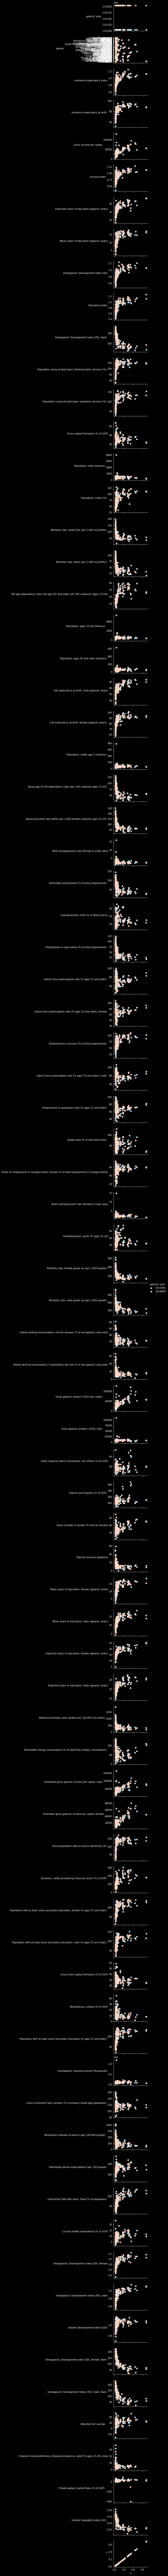

In [98]:
data = data_train.loc[data_train['galactic year'].isin([1013042, 1014049])]
g = sns.pairplot(data, x_vars=['y'], y_vars=data_corr.columns, hue='galactic year', palette='RdBu_r')

for ax in g.axes.flatten():
    ax.yaxis.get_label().set_rotation(0)
    ax.yaxis.get_label().set_horizontalalignment('right')

In [99]:
corr_cols_years = data.corr().columns[data.corr()['y'] > 0.5]

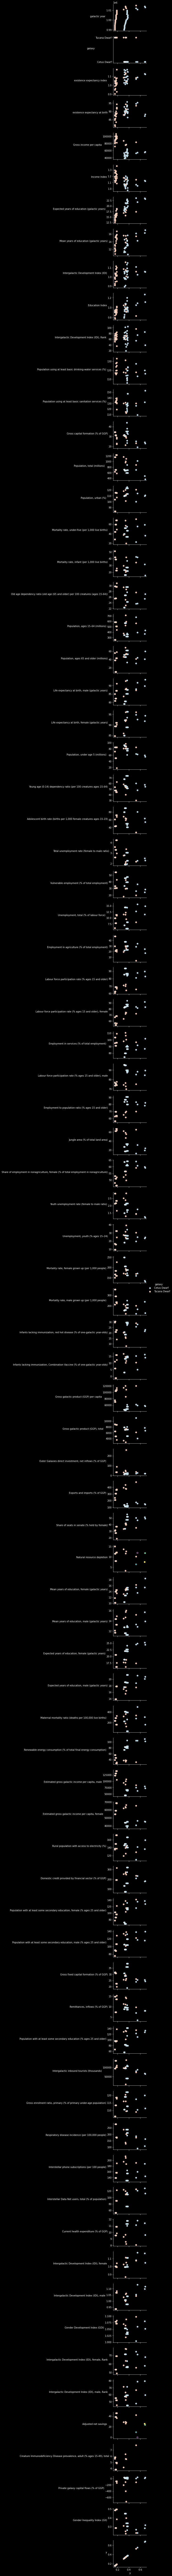

In [194]:
data = data_train.loc[data_train['galaxy'].isin(['Cetus Dwarf', 'Tucana Dwarf'])]
g = sns.pairplot(data, x_vars=['y'], y_vars=data_corr.columns, hue='galaxy', palette='RdBu_r')

for ax in g.axes.flatten():
    ax.yaxis.get_label().set_rotation(0)
    ax.yaxis.get_label().set_horizontalalignment('right')

In [101]:
corr_cols_galaxy = data.corr().columns[data.corr()['y'] > 0.5]

In [111]:
corr_cols = list(corr_cols_galaxy.intersection(corr_cols_years))
corr_cols.remove('y')
corr_cols

['Expected years of education (galactic years)',
 'Education Index',
 'Life expectancy at birth, male (galactic years)',
 'Life expectancy at birth, female (galactic years)',
 'Mean years of education, female (galactic years)',
 'Expected years of education, female (galactic years)',
 'Expected years of education, male (galactic years)',
 'Population with at least some secondary education, female (% ages 25 and older)',
 'Population with at least some secondary education, male (% ages 25 and older)',
 'Interstellar Data Net users, total (% of population)',
 'Intergalactic Development Index (IDI), female',
 'Intergalactic Development Index (IDI), male']

### Перекос

In [27]:
data_train.skew(axis=0).sort_values(ascending=False).head(20)

Outer Galaxies direct investment, net inflows (% of GGP)                          13.68
Gross galactic product (GGP), total                                               10.40
Total unemployment rate (female to male ratio)                                     9.28
Remittances, inflows (% of GGP)                                                    7.83
Intergalactic inbound tourists (thousands)                                         6.58
Population, ages 65 and older (millions)                                           6.31
Population, ages 15–64 (millions)                                                  6.27
Population, total (millions)                                                       6.15
Population, under age 5 (millions)                                                 6.11
Youth unemployment rate (female to male ratio)                                     5.64
Natural resource depletion                                                         3.15
Creature Immunodeficiency Diseas

In [84]:
pd.concat([data_train.agg(['min', 'max', 'mean', ]).transpose(), data_test.agg(['min', 'max', 'mean', ]).transpose()], axis=1)

min  \
galactic year                                                   990,025.00   
galaxy                                              Andromeda Galaxy (M31)   
existence expectancy index                                            0.23   
existence expectancy at birth                                        34.24   
Gross income per capita                                            -126.91   
Income Index                                                          0.29   
Expected years of education (galactic years)                          3.80   
Mean years of education (galactic years)                              1.93   
Intergalactic Development Index (IDI)                                 0.27   
Education Index                                                       0.19   
Intergalactic Development Index (IDI), Rank                           9.93   
Population using at least basic drinking-water ...                   33.14   
Population using at least basic sanitation serv...                   10.61   
Gross capital formation (% of GGP)                                    2.49   
Population, total (millions)                                       -160.44   
Population, urban (%)                                                20.78   
Mortality rate, under-five (per 1,000 live births)                    9.72   
Mortality rate, infant (per 1,000 live births)                       12.79   
Old age dependency ratio (old age (65 and older...                    4.30   
Population, ages 15–64 (millions)                                   -91.29   
Population, ages 65 and older (millions)                            -23.66   
Life expectancy at birth, male (galactic years)                      39.16   
Life expectancy at birth, female (galactic years)                    40.94   
Population, under age 5 (millions)                                   -2.09   
Young age (0-14) dependency ratio (per 100 crea...                   11.62   
Adolescent birth rate (births per 1,000 female ...                   14.34   
Total unemployment rate (female to male ratio)                        0.93   
Vulnerable employment (% of total employment)                        11.66   
Unemployment, total (% of labour force)                               1.96   
Employment in agriculture (% of total employment)                    -0.68   
Labour force participation rate (% ages 15 and ...                   44.24   
Labour force participation rate (% ages 15 and ...                   14.41   
Employment in services (% of total employment)                       13.82   
Labour force participation rate (% ages 15 and ...                   47.24   
Employment to population ratio (% ages 15 and o...                   33.40   
Jungle area (% of total land area)                                    7.13   
Share of employment in nonagriculture, female (...                   13.02   
Youth unemployment rate (female to male ratio)                        0.61   
Unemployment, youth (% ages 15–24)                                    4.48   
Mortality rate, female grown up (per 1,000 people)                   65.33   
Mortality rate, male grown up (per 1,000 people)                     75.17   
Infants lacking immunization, red hot disease (...                    2.34   
Infants lacking immunization, Combination Vacci...                   -1.32   
Gross galactic product (GGP) per capita                           4,007.14   
Gross galactic product (GGP), total                                -933.22   
Outer Galaxies direct investment, net inflows (...                   -5.27   
Exports and imports (% of GGP)                                       18.99   
Share of seats in senate (% held by female)                           4.23   
Natural resource depletion                                           -0.37   
Mean years of education, female (galactic years)                      1.32   
Mean years of education, male (galactic years)                        2.95   
Expected years 

### Features

Функция для анализа данных:

In [231]:
def data_desc(data, cols=[], start_col=0, n_cols=10):
    """Description for data
    data - Dataset;
    cols - Columns for subset;
    start_col - Start No. of column subset;
    n_cols - Number of columns in subset. Default 10 for good screen fitting;
    """
    if not cols:
        i = start_col
        cols = list(data.drop(['galaxy', 'galactic year'], axis=1).columns[start_col:min(data.shape[1], start_col + n_cols)])
    cols.append('y')
    print('Data head:', '\n')
    display(data[cols].head(10))
    print('Data description:', '\n')
    display(data[cols].describe(include='all'))
#    print('Data fullness:', '\n')
#    rcParams['figure.figsize'] = 18, 9
#    sns.heatmap(data.groupby(['galactic year'])[['galaxy'] + cols].count(), cmap="Reds", linewidths=0.05, annot=True, fmt='d');
#     plt.show()
    #display(data.groupby(['galactic year'])[['galaxy'] + cols].count())
    print('Data distribution:', '\n')
    rcParams['figure.figsize'] = 18, 9
    data[cols].hist(bins=50);
    plt.show()
    fig, ax = plt.subplots(4, 3, figsize=(18, 18), constrained_layout=True)
    for i, c in enumerate(cols):
        data_wrk = data[c]
        plt.title(c)
        qqplot(data_wrk, line='s', ax=ax[i//3, i%3])
        ax[i//3, i%3].set_title(c)
        ax[i//3, i%3].set_aspect('box')
    plt.show()
#    sns.pairplot(data)
#    plt.show()
    print('Data correlation:', '\n')
    display(pd.concat([data[cols].corrwith(data['y'], method='spearman'), data[cols].skew(axis=0)], axis=1, keys=['corr', 'skew']))
#    print()
#    sns.heatmap(data[cols + ['y']].corr(), cmap="RdYlBu", vmin=-1, vmax=1)
#    print('\n', '-' * 50, '\n')

Для первых 10 признаков:

Data head: 



existence expectancy index  existence expectancy at birth  \
125                         0.76                          72.02   
242                         0.77                          68.28   
465                         0.79                          69.15   
673                         0.82                          74.02   
731                         0.84                          71.63   
914                         0.82                          71.76   
1191                        0.84                          72.30   
1393                        0.73                          72.25   
1455                        0.84                          69.91   
1630                        0.86                          68.07   

      Gross income per capita  Income Index  \
125                 18,445.32          0.65   
242                 17,844.40          0.68   
465                 17,407.79          0.66   
673                 27,287.95          0.83   
731                 18,470.44          0.58   
914                 17,164.46          0.75   
1191                24,638.25          0.57   
1393                22,284.17          0.65   
1455                11,289.54          0.77   
1630                11,326.34          0.72   

      Expected years of education (galactic years)  \
125                                          13.82   
242                                          15.52   
465                                          14.66   
673                                          15.87   
731                                          14.42   
914                                          13.77   
1191                                         16.34   
1393                                         14.31   
1455                                         13.39   
1630                                         13.87   

      Mean years of education (galactic years)  \
125                                        nan   
242                                        nan   
465                                        nan   
673                                        nan   
731                                        nan   
914                                        nan   
1191                                       nan   
1393                                       nan   
1455                                       nan   
1630                                       nan   

      Intergalactic Development Index (IDI)  Education Index  \
125                                     nan              nan   
242                                     nan              nan   
465                                     nan              nan   
673                                     nan              nan   
731                                     nan              nan   
914                                     nan              nan   
1191                                    nan              nan   
1393                                    nan              nan   
1455                                    nan              nan   
1630                                    nan              nan   

      Intergalactic Development Index (IDI), Rank  \
125                                           nan   
242                                           nan   
465                                           nan   
673                                           nan   
731                                           nan   
914                                           nan   
1191                                          nan   
1393                                          nan   
1455                                          nan   
1630                                          nan   

      Population using at least basic drinking-water services (%)    y  
125                                                 nan           0.05  
242                                                 nan           0.05  
465                                                 nan           0.05  
673                    

Data description: 



existence expectancy index  existence expectancy at birth  \
count                    3,864.00                       3,864.00   
mean                         0.87                          76.80   
std                          0.16                          10.46   
min                          0.23                          34.24   
25%                          0.76                          69.96   
50%                          0.91                          79.00   
75%                          0.99                          84.56   
max                          1.25                         100.21   

       Gross income per capita  Income Index  \
count                 3,837.00      3,837.00   
mean                 31,633.24          0.83   
std                  18,736.38          0.19   
min                    -126.91          0.29   
25%                  20,169.12          0.68   
50%                  26,600.77          0.83   
75%                  36,898.63          0.97   
max                 151,072.68          1.36   

       Expected years of education (galactic years)  \
count                                      3,734.00   
mean                                          14.72   
std                                            3.61   
min                                            3.80   
25%                                           12.59   
50%                                           14.95   
75%                                           17.13   
max                                           26.96   

       Mean years of education (galactic years)  \
count                                  3,502.00   
mean                                      10.28   
std                                        3.32   
min                                        1.93   
25%                                        7.65   
50%                                       10.39   
75%                                       12.88   
max                                       19.06   

       Intergalactic Development Index (IDI)  Education Index  \
count                               3,476.00         3,476.00   
mean                                    0.80             0.75   
std                                     0.18             0.20   
min                                     0.27             0.19   
25%                                     0.67             0.60   
50%                                     0.82             0.76   
75%                                     0.94             0.89   
max                                     1.23             1.27   

       Intergalactic Development Index (IDI), Rank  \
count                                     3,435.00   
mean                                        135.10   
std                                          52.45   
min                                           9.93   
25%                                          92.06   
50%                                         135.90   
75%                                         175.29   
max                                         278.79   

       Population using at least basic drinking-water services (%)        y  
count                                           2,021.00           3,865.00  
mean                                              101.89               0.08  
std                                                20.32               0.06  
min                                                33.14               0.01  
25%                                                89.47               0.05  
50%                                               108.42               0.06  
75%                                               116.90               0.09  
max                                               136.32               0.68

Data distribution: 



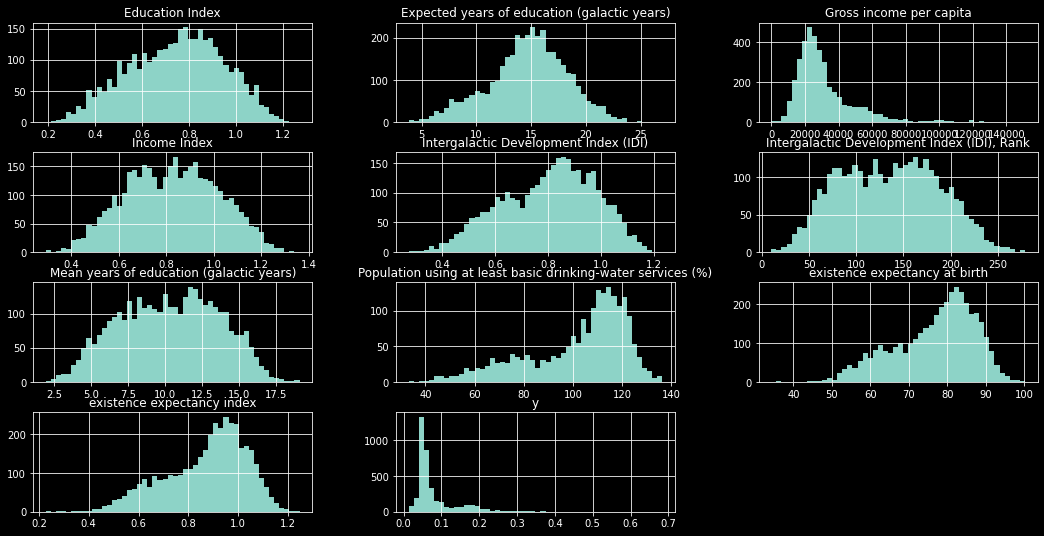

ValueError: could not convert string to float: 'box'

In [232]:
data_desc(data_train, start_col=0)

10 - 20:

Data head: 



Population using at least basic sanitation services (%)  \
125                                                 nan         
242                                                 nan         
465                                                 nan         
673                                                 nan         
731                                                 nan         
914                                                 nan         
1191                                                nan         
1393                                                nan         
1455                                                nan         
1630                                                nan         

      Gross capital formation (% of GGP)  Population, total (millions)  \
125                                71.98                        779.14   
242                                71.98                        779.14   
465                                71.98                        779.14   
673                                71.98                        779.14   
731                                71.98                        779.14   
914                                  nan                        752.32   
1191                                 nan                        752.32   
1393                                 nan                        752.32   
1455                                 nan                        752.32   
1630                                 nan                        752.32   

      Population, urban (%)  \
125                   53.72   
242                   53.72   
465                   53.72   
673                   53.72   
731                   53.72   
914                   64.35   
1191                  64.35   
1393                  64.35   
1455                  64.35   
1630                  64.35   

      Mortality rate, under-five (per 1,000 live births)  \
125                                              136.15    
242                                              136.15    
465                                              136.15    
673                                              136.15    
731                                              136.15    
914                                              137.14    
1191                                             137.14    
1393                                             137.14    
1455                                             137.14    
1630                                             137.14    

      Mortality rate, infant (per 1,000 live births)  \
125                                            94.37   
242                                            94.37   
465                                            94.37   
673                                            94.37   
731                                            94.37   
914                                            87.50   
1191                                           87.50   
1393                                           87.50   
1455                                           87.50   
1630                                           87.50   

      Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))  \
125                                               13.49                                  
242                                               13.49                                  
465                                               13.49                                  
673                                               13.49                                  
731                                               13.49                                  
914                                               11.60                                  
1191                                              11.60                                  
1393                                              11.60                                  
1455                                         

Data description: 



Population using at least basic sanitation services (%)  \
count                                           2,015.00         
mean                                               99.94         
std                                                32.36         
min                                                10.61         
25%                                                73.45         
50%                                               110.27         
75%                                               125.64         
max                                               161.27         

       Gross capital formation (% of GGP)  Population, total (millions)  \
count                            3,324.00                      3,865.00   
mean                                31.28                        811.47   
std                                  8.51                        565.46   
min                                  2.49                       -160.44   
25%                                 26.48                        598.00   
50%                                 30.97                        762.53   
75%                                 35.79                        951.92   
max                                 72.31                      7,993.32   

       Population, urban (%)  \
count               3,865.00   
mean                   75.54   
std                    24.11   
min                    20.78   
25%                    55.78   
50%                    76.51   
75%                    95.48   
max                   129.91   

       Mortality rate, under-five (per 1,000 live births)  \
count                                           3,865.00    
mean                                              106.45    
std                                                62.49    
min                                                 9.72    
25%                                                60.51    
50%                                                85.70    
75%                                               137.63    
max                                               379.42    

       Mortality rate, infant (per 1,000 live births)  \
count                                        3,865.00   
mean                                            70.62   
std                                             37.45   
min                                             12.79   
25%                                             42.09   
50%                                             58.84   
75%                                             93.85   
max                                            208.50   

       Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))  \
count                                           3,842.00                                  
mean                                               18.47                                  
std                                                 6.97                                  
min                                                 4.30                                  
25%                                                13.56                                  
50%                                                16.49                                  
75%                                                22.68                                  
max                                                52.22                                  

       Population, ages 15–64 (millions)  \
count                           3,842.00   
mean                              531.11   
std                               359.25   
min                               -91.29   
25%                               389.99   
50%                               501.58   
75%                               617.05   
max                             5,542.81   

       Population, ages 65 and older (millions)  \
count                                  3,842.00   
mean                                      58.91   
std          

Data distribution: 



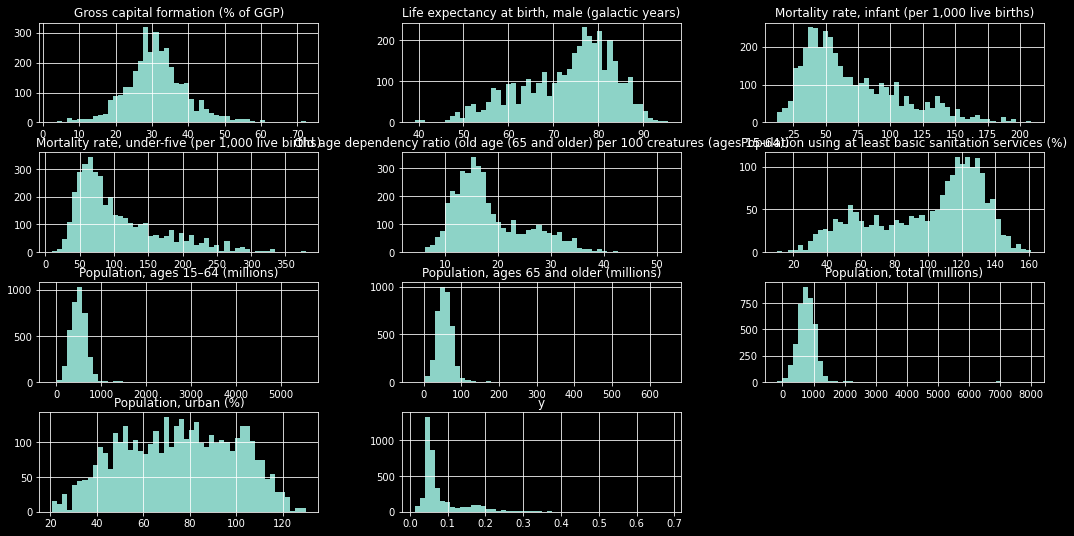

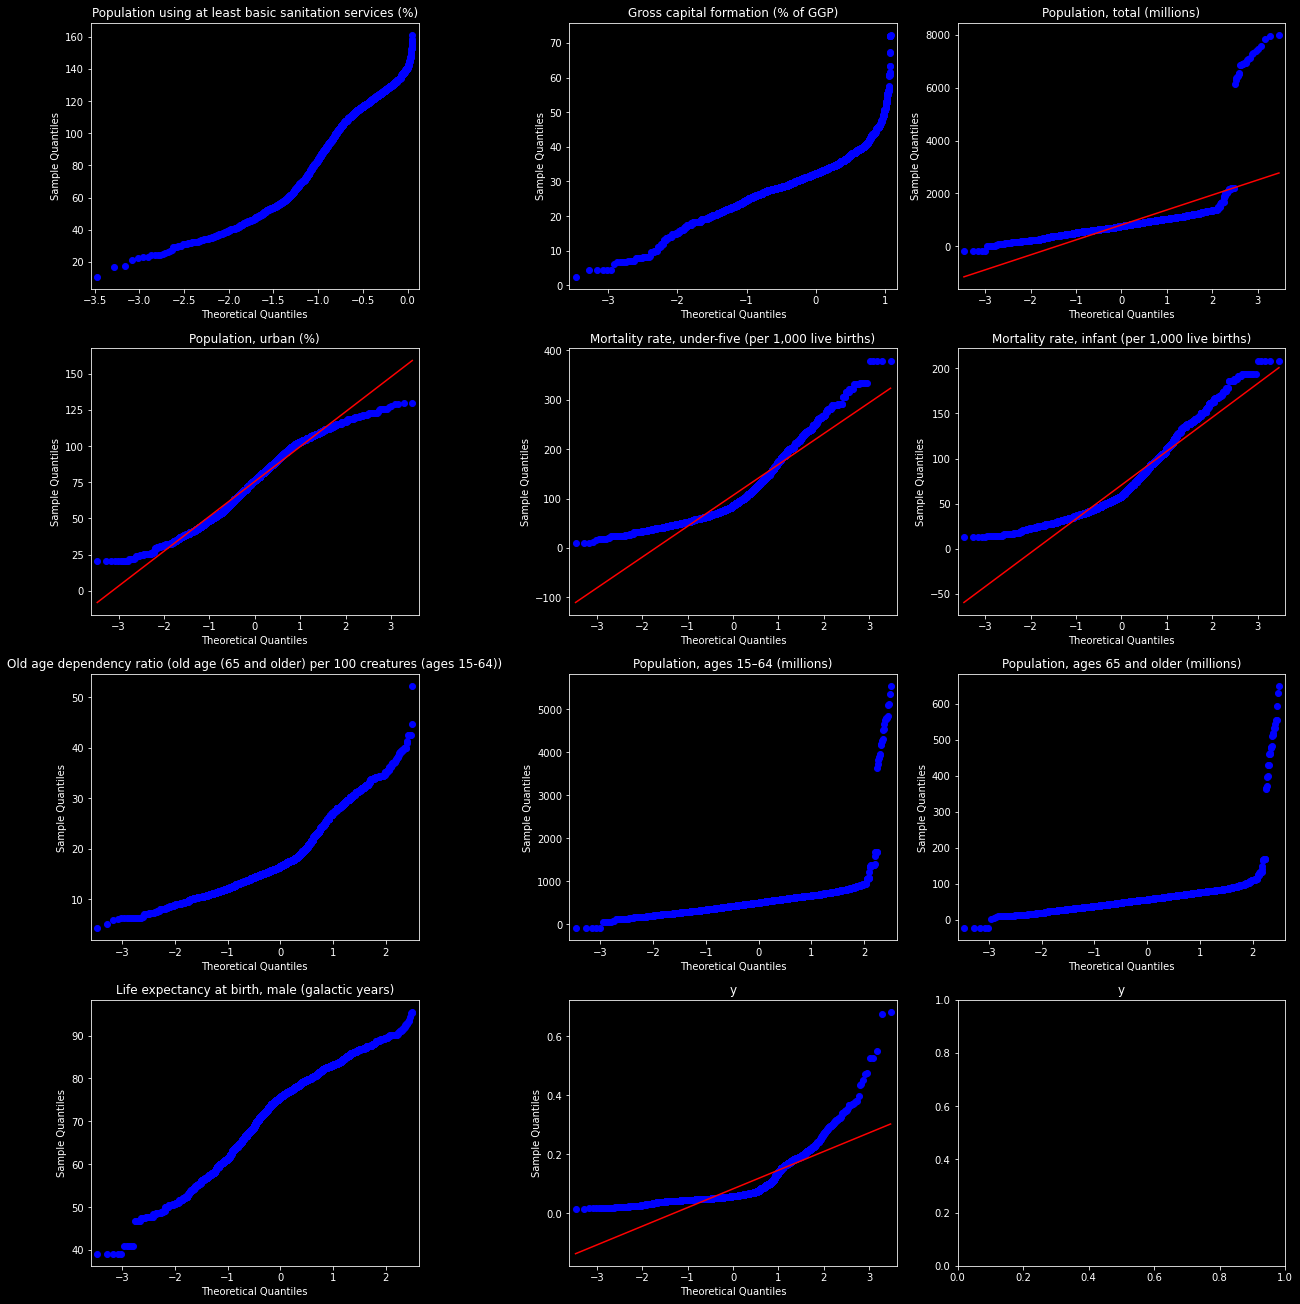

Data correlation: 



corr  skew
Population using at least basic sanitation serv...  0.66 -0.58
Gross capital formation (% of GGP)                  0.16  0.43
Population, total (millions)                        0.02  8.34
Population, urban (%)                               0.57 -0.08
Mortality rate, under-five (per 1,000 live births) -0.67  1.24
Mortality rate, infant (per 1,000 live births)     -0.68  0.97
Old age dependency ratio (old age (65 and older...  0.68  0.92
Population, ages 15–64 (millions)                  -0.03  8.64
Population, ages 65 and older (millions)            0.02  8.63
Life expectancy at birth, male (galactic years)     0.69 -0.59
y                                                   1.00  2.66

In [212]:
data_desc(data_train, start_col=10)

20-30:

Data head: 



Life expectancy at birth, female (galactic years)  \
125                                               70.01   
242                                               70.01   
465                                               70.01   
673                                               70.01   
731                                               70.01   
914                                               72.59   
1191                                              72.59   
1393                                              72.59   
1455                                              72.59   
1630                                              72.59   

      Population, under age 5 (millions)  \
125                                13.36   
242                                13.36   
465                                13.36   
673                                13.36   
731                                13.36   
914                                48.37   
1191                               48.37   
1393                               48.37   
1455                               48.37   
1630                               48.37   

      Young age (0-14) dependency ratio (per 100 creatures ages 15-64)  \
125                                               97.58                  
242                                               97.58                  
465                                               97.58                  
673                                               97.58                  
731                                               97.58                  
914                                              102.65                  
1191                                             102.65                  
1393                                             102.65                  
1455                                             102.65                  
1630                                             102.65                  

      Adolescent birth rate (births per 1,000 female creatures ages 15-19)  \
125                                               94.60                      
242                                               94.60                      
465                                               94.60                      
673                                               94.60                      
731                                               94.60                      
914                                               86.70                      
1191                                              86.70                      
1393                                              86.70                      
1455                                              86.70                      
1630                                              86.70                      

      Total unemployment rate (female to male ratio)  \
125                                              nan   
242                                              nan   
465                                              nan   
673                                              nan   
731                                              nan   
914                                              nan   
1191                                             nan   
1393                                             nan   
1455                                             nan   
1630                                             nan   

      Vulnerable employment (% of total employment)  \
125                                             nan   
242                                             nan   
465                                             nan   
673                                             nan   
731                                             nan   
914                                             nan   
1191                                            nan   
1393                                            nan   
1455                                            nan   
1630                          

Data description: 



Life expectancy at birth, female (galactic years)  \
count                                           3,842.00   
mean                                               78.69   
std                                                11.06   
min                                                40.94   
25%                                                70.41   
50%                                                81.62   
75%                                                87.26   
max                                               101.68   

       Population, under age 5 (millions)  \
count                            3,842.00   
mean                                82.29   
std                                 56.32   
min                                 -2.09   
25%                                 60.95   
50%                                 78.66   
75%                                 94.59   
max                                780.96   

       Young age (0-14) dependency ratio (per 100 creatures ages 15-64)  \
count                                           3,842.00                  
mean                                               82.04                  
std                                                25.33                  
min                                                11.62                  
25%                                                60.23                  
50%                                                82.01                  
75%                                               103.84                  
max                                               137.20                  

       Adolescent birth rate (births per 1,000 female creatures ages 15-19)  \
count                                           3,842.00                      
mean                                              118.67                      
std                                                53.96                      
min                                                14.34                      
25%                                                77.00                      
50%                                               109.32                      
75%                                               151.72                      
max                                               289.81                      

       Total unemployment rate (female to male ratio)  \
count                                        3,625.00   
mean                                             2.73   
std                                              1.15   
min                                              0.93   
25%                                              2.19   
50%                                              2.56   
75%                                              3.08   
max                                             29.66   

       Vulnerable employment (% of total employment)  \
count                                       3,625.00   
mean                                           69.75   
std                                            29.98   
min                                            11.66   
25%                                            45.35   
50%                                            65.38   
75%                                            94.94   
max                                           143.93   

       Unemployment, total (% of labour force)  \
count                                 3,625.00   
mean                                     14.66   
std                                       6.93   
min                                       1.96   
25%                                       9.76   
50%                                      13.24   
75%                                      17.98   
max                                      44.85   

       Employment in agriculture (% of total employment)  \
count                                           3,625.00   
mean                                               55.93   
std                   

Data distribution: 



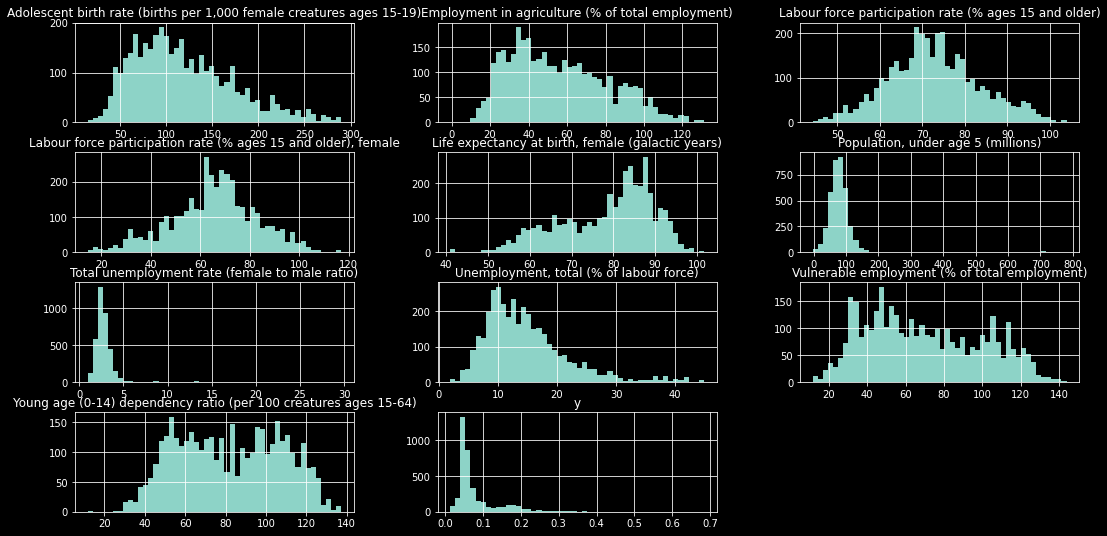

Data correlation: 



corr  skew
Life expectancy at birth, female (galactic years)   0.74 -0.64
Population, under age 5 (millions)                  0.00  8.45
Young age (0-14) dependency ratio (per 100 crea... -0.72  0.02
Adolescent birth rate (births per 1,000 female ... -0.64  0.71
Total unemployment rate (female to male ratio)     -0.02  7.36
Vulnerable employment (% of total employment)      -0.65  0.29
Unemployment, total (% of labour force)             0.09  1.34
Employment in agriculture (% of total employment)  -0.62  0.47
Labour force participation rate (% ages 15 and ... -0.21  0.18
Labour force participation rate (% ages 15 and ... -0.13 -0.20
y                                                   1.00  2.66

In [213]:
data_desc(data_train, start_col=20)

30-40:

Data head: 



Employment in services (% of total employment)  \
train 125                                              nan   
      242                                              nan   
      465                                              nan   
      673                                              nan   
      731                                              nan   
      914                                              nan   
      1191                                             nan   
      1393                                             nan   
      1455                                             nan   
      1630                                             nan   

            Labour force participation rate (% ages 15 and older), male  \
train 125                                                 nan             
      242                                                 nan             
      465                                                 nan             
      673                                                 nan             
      731                                                 nan             
      914                                                 nan             
      1191                                                nan             
      1393                                                nan             
      1455                                                nan             
      1630                                                nan             

            Employment to population ratio (% ages 15 and older)  \
train 125                                                 nan      
      242                                                 nan      
      465                                                 nan      
      673                                                 nan      
      731                                                 nan      
      914                                                 nan      
      1191                                                nan      
      1393                                                nan      
      1455                                                nan      
      1630                                                nan      

            Jungle area (% of total land area)  \
train 125                                47.14   
      242                                47.14   
      465                                47.14   
      673                                47.14   
      731                                47.14   
      914                                28.86   
      1191                               28.86   
      1393                               28.86   
      1455                               28.86   
      1630                               28.86   

            Share of employment in nonagriculture, female (% of total employment in nonagriculture)  \
train 125                                                 nan                                         
      242                                                 nan                                         
      465                                                 nan                                         
      673                                                 nan                                         
      731                                                 nan                                         
      914                                                 nan                                         
      1191                                                nan                                         
      1393                                                nan                                         
      1455                                                nan                                         
      1630                                                nan                                         

            Youth unemployment rate (female to male ratio)  \
train 1

Data description: 



Employment in services (% of total employment)  \
count                                        3,625.00   
mean                                            66.30   
std                                             19.08   
min                                             13.82   
25%                                             52.40   
50%                                             67.69   
75%                                             81.03   
max                                            110.76   

       Labour force participation rate (% ages 15 and older), male  \
count                                           3,802.00             
mean                                               83.82             
std                                                 9.12             
min                                                47.24             
25%                                                77.64             
50%                                                84.51             
75%                                                90.03             
max                                               106.82             

       Employment to population ratio (% ages 15 and older)  \
count                                           3,625.00      
mean                                               69.14      
std                                                12.13      
min                                                33.40      
25%                                                61.22      
50%                                                69.41      
75%                                                76.20      
max                                               103.96      

       Jungle area (% of total land area)  \
count                            3,787.00   
mean                                55.41   
std                                 25.09   
min                                  7.13   
25%                                 34.70   
50%                                 52.99   
75%                                 73.17   
max                                134.47   

       Share of employment in nonagriculture, female (% of total employment in nonagriculture)  \
count                                           3,625.00                                         
mean                                               49.60                                         
std                                                12.00                                         
min                                                13.02                                         
25%                                                44.52                                         
50%                                                51.93                                         
75%                                                57.27                                         
max                                                79.49                                         

       Youth unemployment rate (female to male ratio)  \
count                                        3,621.00   
mean                                             2.23   
std                                              0.73   
min                                              0.61   
25%                                              1.81   
50%                                              2.15   
75%                                              2.54   
max                                             14.80   

       Unemployment, youth (% ages 15–24)  \
count                            3,621.00   
mean                                29.36   
std                                 12.89   
min                                  4.48   
25%                                 20.15   
50%                                 26.29   
75%                                 36.29   
max                                 84.10   

       Mortality rate, female grown up (per 1,000 people)  \
count                   

Data fullness: 

Data distribution: 



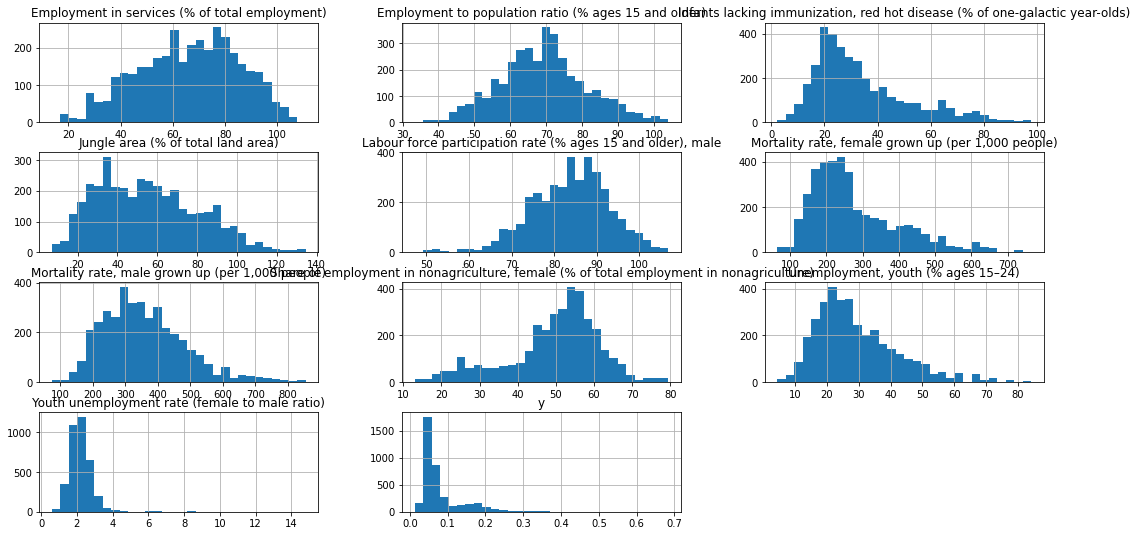

In [76]:
data_desc(data_train, start_col=30)

40-50:

Data head: 



Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)  \
train 125                                               10.56                                 
      242                                               10.56                                 
      465                                               10.56                                 
      673                                               10.56                                 
      731                                               10.56                                 
      914                                               34.23                                 
      1191                                              34.23                                 
      1393                                              34.23                                 
      1455                                              34.23                                 
      1630                                              34.23                                 

            Gross galactic product (GGP) per capita  \
train 125                                 18,703.50   
      242                                 18,703.50   
      465                                 18,703.50   
      673                                 18,703.50   
      731                                 18,703.50   
      914                                 26,135.34   
      1191                                26,135.34   
      1393                                26,135.34   
      1455                                26,135.34   
      1630                                26,135.34   

            Gross galactic product (GGP), total  \
train 125                              5,207.63   
      242                              5,207.63   
      465                              5,207.63   
      673                              5,207.63   
      731                              5,207.63   
      914                              6,831.08   
      1191                             6,831.08   
      1393                             6,831.08   
      1455                             6,831.08   
      1630                             6,831.08   

            Outer Galaxies direct investment, net inflows (% of GGP)  \
train 125                                               14.92          
      242                                               14.92          
      465                                               14.92          
      673                                               14.92          
      731                                               14.92          
      914                                               10.25          
      1191                                              10.25          
      1393                                              10.25          
      1455                                              10.25          
      1630                                              10.25          

            Exports and imports (% of GGP)  \
train 125                           166.98   
      242                           166.98   
      465                           166.98   
      673                           166.98   
      731                           166.98   
      914                           161.49   
      1191                          161.49   
      1393                          161.49   
      1455                          161.49   
      1630                          161.49   

            Share of seats in senate (% held by female)  \
train 125                                           nan   
      242                                           nan   
      465                                           nan   
      673                                           nan   
      731                                           nan   
      914                                         11.23   
      1191                                        11.23   
      1393                

Data description: 



Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)  \
count                                           3,672.00                                 
mean                                               19.74                                 
std                                                12.26                                 
min                                                -1.32                                 
25%                                                12.27                                 
50%                                                15.87                                 
75%                                                22.73                                 
max                                                72.43                                 

       Gross galactic product (GGP) per capita  \
count                                 3,631.00   
mean                                 32,118.94   
std                                  18,268.30   
min                                   4,007.14   
25%                                  20,819.94   
50%                                  27,185.06   
75%                                  37,646.68   
max                                 134,636.65   

       Gross galactic product (GGP), total  \
count                             3,631.00   
mean                              7,582.53   
std                               6,074.59   
min                                -933.22   
25%                               5,450.99   
50%                               7,044.15   
75%                               8,674.73   
max                             112,391.32   

       Outer Galaxies direct investment, net inflows (% of GGP)  \
count                                           3,477.00          
mean                                               17.54          
std                                                15.90          
min                                                -5.27          
25%                                                12.69          
50%                                                16.39          
75%                                                20.17          
max                                               362.55          

       Exports and imports (% of GGP)  \
count                        3,425.00   
mean                           129.28   
std                             50.48   
min                             18.99   
25%                             97.57   
50%                            123.18   
75%                            151.75   
max                            477.06   

       Share of seats in senate (% held by female)  \
count                                     2,602.00   
mean                                         24.61   
std                                          10.42   
min                                           4.23   
25%                                          17.37   
50%                                          22.41   
75%                                          30.50   
max                                          69.85   

       Natural resource depletion  \
count                    3,368.00   
mean                        13.56   
std                          9.82   
min                         -0.37   
25%                          8.48   
50%                         11.01   
75%                         15.09   
max                        100.41   

       Mean years of education, female (galactic years)  \
count                                          3,327.00   
mean                                              10.06   
std                                                3.61   
min                                                1.32   
25%                                                7.13   
50%                                               10.13   
75%                                               13.06   
max                                               18.49   

   

Data fullness: 

Data distribution: 



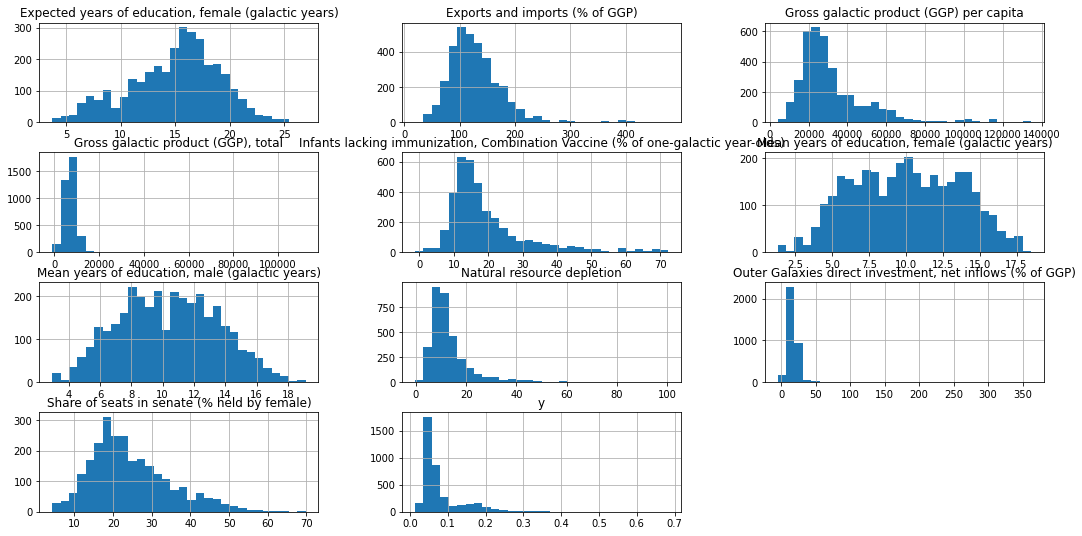

In [77]:
data_desc(data_train, start_col=40)

50-60:

In [78]:
data_desc(data_train, start_col=50)

Data head: 



Expected years of education, male (galactic years)  \
train 125                                               13.05    
      242                                               13.05    
      465                                               13.05    
      673                                               13.05    
      731                                               13.05    
      914                                               13.85    
      1191                                              13.85    
      1393                                              13.85    
      1455                                              13.85    
      1630                                              13.85    

            Maternal mortality ratio (deaths per 100,000 live births)  \
train 125                                              648.66           
      242                                              648.66           
      465                                              648.66           
      673                                              648.66           
      731                                              648.66           
      914                                              513.44           
      1191                                             513.44           
      1393                                             513.44           
      1455                                             513.44           
      1630                                             513.44           

            Renewable energy consumption (% of total final energy consumption)  \
train 125                                               31.94                    
      242                                               31.94                    
      465                                               31.94                    
      673                                               31.94                    
      731                                               31.94                    
      914                                               24.29                    
      1191                                              24.29                    
      1393                                              24.29                    
      1455                                              24.29                    
      1630                                              24.29                    

            Estimated gross galactic income per capita, male  \
train 125                                                nan   
      242                                                nan   
      465                                                nan   
      673                                                nan   
      731                                                nan   
      914                                                nan   
      1191                                               nan   
      1393                                               nan   
      1455                                               nan   
      1630                                               nan   

            Estimated gross galactic income per capita, female  \
train 125                                                 nan    
      242                                                 nan    
      465                                                 nan    
      673                                                 nan    
      731                                                 nan    
      914                                                 nan    
      1191                                                nan    
      1393                                                nan    
      1455                                                nan    
      1630                                                nan    

            Rural population with access to electricity (%)  \
train 125                                               nan   
      242           

Data description: 



Expected years of education, male (galactic years)  \
count                                           3,160.00    
mean                                               14.36    
std                                                 3.32    
min                                                 3.84    
25%                                                12.59    
50%                                                14.55    
75%                                                16.56    
max                                                29.05    

       Maternal mortality ratio (deaths per 100,000 live births)  \
count                                           3,842.00           
mean                                              587.56           
std                                               395.39           
min                                                39.18           
25%                                               329.01           
50%                                               454.29           
75%                                               740.98           
max                                             3,178.33           

       Renewable energy consumption (% of total final energy consumption)  \
count                                           3,773.00                    
mean                                               64.71                    
std                                                33.24                    
min                                                -1.05                    
25%                                                37.68                    
50%                                                56.66                    
75%                                                91.27                    
max                                               146.13                    

       Estimated gross galactic income per capita, male  \
count                                          2,900.00   
mean                                          40,793.59   
std                                           24,887.23   
min                                            4,247.34   
25%                                           25,922.40   
50%                                           33,503.94   
75%                                           46,724.58   
max                                          187,663.57   

       Estimated gross galactic income per capita, female  \
count                                           2,900.00    
mean                                           21,778.41    
std                                            12,168.26    
min                                              -947.54    
25%                                            14,118.61    
50%                                            18,580.57    
75%                                            25,629.92    
max                                            83,638.78    

       Rural population with access to electricity (%)  \
count                                         2,755.00   
mean                                            107.40   
std                                              40.43   
min                                               1.53   
25%                                              73.91   
50%                                             123.85   
75%                                             138.27   
max                                             174.91   

       Domestic credit provided by financial sector (% of GGP)  \
count                                           3,148.00         
mean                                              112.10         
std                                                56.92         
min                                               -38.30         
25%                                                76.15         
50%                                                99.52         
75%                                               134.59         
max              

Data fullness: 

Data distribution: 



60-70:

In [79]:
data_desc(data_train, start_col=60)

Data head: 



Remittances, inflows (% of GGP)  \
train 125                             16.99   
      242                             16.99   
      465                             16.99   
      673                             16.99   
      731                             16.99   
      914                               nan   
      1191                              nan   
      1393                              nan   
      1455                              nan   
      1630                              nan   

            Population with at least some secondary education (% ages 25 and older)  \
train 125                                                 nan                         
      242                                                 nan                         
      465                                                 nan                         
      673                                                 nan                         
      731                                                 nan                         
      914                                                 nan                         
      1191                                                nan                         
      1393                                                nan                         
      1455                                                nan                         
      1630                                                nan                         

            Intergalactic inbound tourists (thousands)  \
train 125                                          nan   
      242                                          nan   
      465                                          nan   
      673                                          nan   
      731                                          nan   
      914                                    92,234.50   
      1191                                   92,234.50   
      1393                                   92,234.50   
      1455                                   92,234.50   
      1630                                   92,234.50   

            Gross enrolment ratio, primary (% of primary under-age population)  \
train 125                                              127.53                    
      242                                              127.53                    
      465                                              127.53                    
      673                                              127.53                    
      731                                              127.53                    
      914                                              134.22                    
      1191                                             134.22                    
      1393                                             134.22                    
      1455                                             134.22                    
      1630                                             134.22                    

            Respiratory disease incidence (per 100,000 people)  \
train 125                                                 nan    
      242                                                 nan    
      465                                                 nan    
      673                                                 nan    
      731                                                 nan    
      914                                                 nan    
      1191                                                nan    
      1393                                                nan    
      1455                                                nan    
      1630                                                nan    

            Interstellar phone subscriptions (per 100 people)  \
train 125                                                 nan   
      242                                                 nan   
      465                                                 nan   
      6

Data description: 



Remittances, inflows (% of GGP)  \
count                         2,933.00   
mean                             11.59   
std                              10.17   
min                              -0.08   
25%                               7.36   
50%                               9.70   
75%                              12.63   
max                             172.73   

       Population with at least some secondary education (% ages 25 and older)  \
count                                           3,168.00                         
mean                                               75.76                         
std                                                28.62                         
min                                                 9.87                         
25%                                                51.20                         
50%                                                74.37                         
75%                                                96.34                         
max                                               149.49                         

       Intergalactic inbound tourists (thousands)  \
count                                    2,688.00   
mean                                   106,660.42   
std                                     74,178.34   
min                                     -9,669.28   
25%                                     78,999.13   
50%                                    101,626.16   
75%                                    123,159.87   
max                                  1,228,843.07   

       Gross enrolment ratio, primary (% of primary under-age population)  \
count                                           3,243.00                    
mean                                              113.78                    
std                                                19.12                    
min                                                35.86                    
25%                                               108.36                    
50%                                               116.92                    
75%                                               123.92                    
max                                               178.40                    

       Respiratory disease incidence (per 100,000 people)  \
count                                           2,038.00    
mean                                              322.71    
std                                               207.07    
min                                                31.69    
25%                                               194.73    
50%                                               261.31    
75%                                               376.12    
max                                             1,380.91    

       Interstellar phone subscriptions (per 100 people)  \
count                                           2,017.00   
mean                                               92.58   
std                                                46.78   
min                                                18.09   
25%                                                53.48   
50%                                                79.45   
75%                                               127.88   
max                                               271.31   

       Interstellar Data Net users, total (% of population)  \
count                                           1,967.00      
mean                                               48.37      
std                                                26.49      
min                                                 0.51      
25%                                                29.85      
50%                                                39.44      
75%                                                62.22      
max                                               141.38      

       Current health expenditure (% of GGP)  \
count     

Data fullness: 

Data distribution: 



70-80:

Data head: 



Gender Development Index (GDI)  \
train 125                              nan   
      242                              nan   
      465                              nan   
      673                              nan   
      731                              nan   
      914                              nan   
      1191                             nan   
      1393                             nan   
      1455                             nan   
      1630                             nan   

            Intergalactic Development Index (IDI), female, Rank  \
train 125                                                 nan     
      242                                                 nan     
      465                                                 nan     
      673                                                 nan     
      731                                                 nan     
      914                                                 nan     
      1191                                                nan     
      1393                                                nan     
      1455                                                nan     
      1630                                                nan     

            Intergalactic Development Index (IDI), male, Rank  \
train 125                                                 nan   
      242                                                 nan   
      465                                                 nan   
      673                                                 nan   
      731                                                 nan   
      914                                                 nan   
      1191                                                nan   
      1393                                                nan   
      1455                                                nan   
      1630                                                nan   

            Adjusted net savings   \
train 125                     nan   
      242                     nan   
      465                     nan   
      673                     nan   
      731                     nan   
      914                     nan   
      1191                    nan   
      1393                    nan   
      1455                    nan   
      1630                    nan   

            Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total  \
train 125                                                 nan                           
      242                                                 nan                           
      465                                                 nan                           
      673                                                 nan                           
      731                                                 nan                           
      914                                                 nan                           
      1191                                                nan                           
      1393                                                nan                           
      1455                                                nan                           
      1630                                                nan                           

            Private galaxy capital flows (% of GGP)  \
train 125                                     55.48   
      242                                     55.48   
      465                                     55.48   
      673                                     55.48   
      731                                     55.48   
      914                                       nan   
      1191                                      nan   
      1393                                      nan   
      1455                                      nan   
      1630                                      nan   

            Gender Inequality Index (GII)    y    y  
tra

Data description: 



Gender Development Index (GDI)  \
count                        2,373.00   
mean                             1.00   
std                              0.09   
min                              0.47   
25%                              0.95   
50%                              1.02   
75%                              1.06   
max                              1.18   

       Intergalactic Development Index (IDI), female, Rank  \
count                                           2,317.00     
mean                                              117.79     
std                                                44.52     
min                                                23.22     
25%                                                81.38     
50%                                               117.52     
75%                                               150.06     
max                                               232.72     

       Intergalactic Development Index (IDI), male, Rank  \
count                                           2,312.00   
mean                                              117.37   
std                                                44.25   
min                                                16.22   
25%                                                80.03   
50%                                               116.97   
75%                                               153.56   
max                                               233.92   

       Adjusted net savings   \
count               2,617.00   
mean                   21.18   
std                    14.16   
min                   -76.74   
25%                    15.20   
50%                    21.67   
75%                    29.13   
max                    61.90   

       Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total  \
count                                           2,875.00                           
mean                                                6.25                           
std                                                 4.55                           
min                                                -1.19                           
25%                                                 4.02                           
50%                                                 5.19                           
75%                                                 6.70                           
max                                                36.54                           

       Private galaxy capital flows (% of GGP)  Gender Inequality Index (GII)  \
count                                 2,291.00                       2,194.00   
mean                                     24.16                           0.63   
std                                      23.46                           0.21   
min                                    -735.19                           0.09   
25%                                      17.41                           0.46   
50%                                      24.51                           0.65   
75%                                      31.98                           0.79   
max                                      95.94                           1.10   

             y        y  
count 3,865.00 3,865.00  
mean      0.08     0.08  
std       0.06     0.06  
min       0.01     0.01  
25%       0.05     0.05  
50%       0.06     0.06  
75%       0.09     0.09  
max       0.68     0.68

Data fullness: 

Data distribution: 



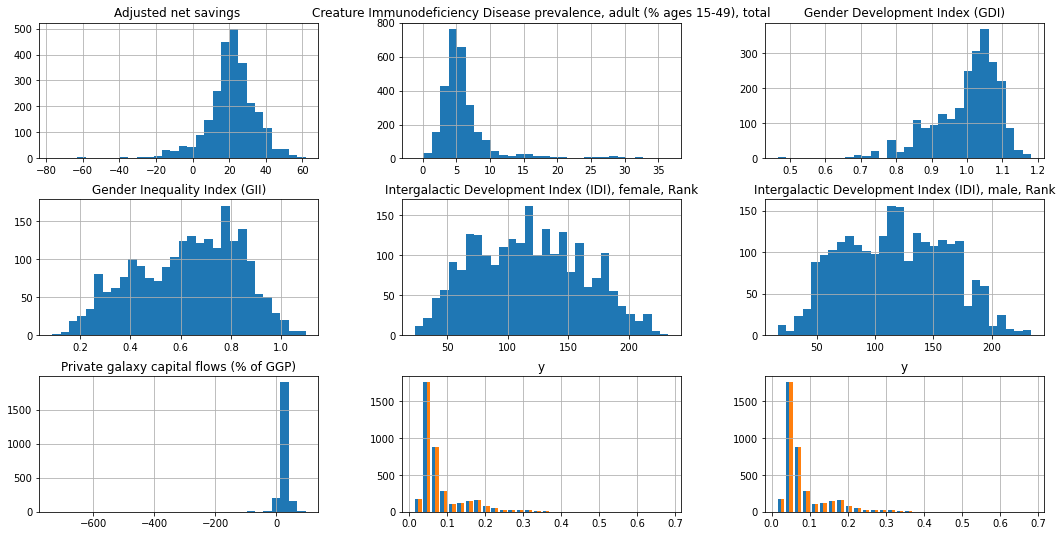

In [80]:
data_desc(data_train, start_col=70)

### check disribution (not done)

### percent cols (not done)

cols_percent = [x for x in data_train.columns if ('%' in x)]
cols_percent = [x for x in cols_percent if (any(data_train[x] > 100))]
(data_train[cols_percent] > 100).sum()

Будем считать, что у инопланетян другие проценты с максимумом > 100%

# Models

## Boosting

In [36]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn import metrics

#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostRegressor(),
    ensemble.BaggingRegressor(),
    ensemble.ExtraTreesRegressor(),
    ensemble.GradientBoostingRegressor(),
    ensemble.RandomForestRegressor(),

    #Gaussian Processes
    gaussian_process.GaussianProcessRegressor(),
    
    #GLM
    linear_model.PassiveAggressiveRegressor(),
    linear_model.RidgeCV(),
    
    #Nearest Neighbor
    neighbors.KNeighborsRegressor(),
    
    #Trees    
    tree.DecisionTreeRegressor(),
    tree.ExtraTreeRegressor(),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBRegressor()    
    ]

#alg = ensemble.GradientBoostingRegressor(criterion='mse', random_state=111)
alg = XGBRegressor()

#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%
   
#score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
cv_results = model_selection.cross_validate(alg, data_train.iloc[:,2:-1], data_train.iloc[:,-1], \
                                            cv  = cv_split, return_train_score=True, scoring='neg_mean_squared_error')

print(cv_results['fit_time'].mean())
print(cv_results['train_score'].mean())
print(cv_results['test_score'].mean())
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
print(cv_results['test_score'].std()*3)   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
alg.fit(data_train.iloc[:,2:-1], data_train.iloc[:,-1])
pred = alg.predict(data_test.sort_index().reset_index(drop=True).iloc[:,2:])



NameError: name 'model_selection' is not defined

In [503]:
pred.max()

0.4395788

## Neural Network

### train_df, test_df

In [106]:
data_train = data_all.loc['train']
data_test = data_all.loc['test'].drop('y', axis=1)
print(data_train.shape, data_test.shape)

(3865, 80) (890, 79)


In [124]:
data_wrk = data_train.copy() #.loc[data_train['galactic year'] >= 1010025]

train_df, test_df = train_test_split(data_wrk, test_size=0.2, random_state=163)

#train_df = train_df.loc[((train_df['y'].mean() - 3 * data_train['y'].std()) < train_df['y']) & \
#                        (train_df['y'] < (train_df['y'].mean() + 3 * data_train['y'].std()))]

print(train_df.shape, test_df.shape);


train_X = train_df.iloc[:,:-1]
train_y = train_df.iloc[:,[-1]]

test_X = test_df.iloc[:,:-1]
test_y = test_df.iloc[:,[-1]]

# preprocess
def preprop_wrk(data, features=[], drop=[]):
    drop += ['galaxy', 'galactic year']
    data.drop(drop, axis=1, inplace=True)
    data[data < 0] = np.nan
    if not features:
        features = data.columns
    return data[features]

features = []
drop = []
#features = corr_cols
#drop = ['Adjusted net savings ', 'Private galaxy capital flows (% of GGP)']
preprop = FunctionTransformer(preprop_wrk, kw_args={'features': features, 'drop': drop})

# imputer
imp = SimpleImputer(strategy='constant', fill_value=0)
#imp = KNNImputer()

#scaler
scale_X = MaxAbsScaler()
#scale_X = MinMaxScaler()
#scale_X = StandardScaler()

# missing indicator
ind = MissingIndicator(features='all')

fnl = make_pipeline(preprop, 
                    make_union(ind, 
                               make_pipeline(imp, 
                                             #norm,
                                             scale_X, 
                                             ),
                              ),                    
                   )

train_X = fnl.fit_transform(train_X)
test_X = fnl.transform(test_X)

transform_y = make_pipeline(
                FunctionTransformer(func=(lambda y: y ** (-1/4) / 10), inverse_func=(lambda y: (10 * y) ** (-4))),
                #MinMaxScaler(),
                )

train_y = transform_y.fit_transform(train_y)
test_y = transform_y.transform(test_y)


from sklearn.utils import shuffle
train_X, train_y = shuffle(train_X, train_y, random_state=87)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape);
print(train_y.max(), train_y.min())

(3092, 80) (773, 80)
(3092, 154) (3092, 1) (773, 154) (773, 1)
y   0.30
dtype: float64 y   0.11
dtype: float64


#### Хорошие модели

#### Create model

In [39]:
def create_model(input_dim, learn_rate=0.001, dropout=.0, dims=[128], l2=1e-9):

    lr_model = keras.models.Sequential()
    lr_model.add(keras.Input(shape=(input_dim,) ))
    lr_model.add(keras.layers.Dropout(dropout))
    for dim in dims:

        lr_model.add(keras.layers.Dense(dim, activation='relu', kernel_initializer='uniform', 
#                                   kernel_regularizer=keras.regularizers.l2(l2),
                                   ))

    #                use_bias=True,
    #                kernel_regularizer=keras.regularizers.l2(1e-6),
    #                bias_regularizer=keras.regularizers.l2(1e-10),
    #                activity_regularizer=keras.regularizers.l2(1e-10)               



    lr_model.add(keras.layers.Dense(1, activation='linear', kernel_initializer='uniform'))

    # compile the model
    lr_model.compile(loss='mean_squared_error', 
                  optimizer=keras.optimizers.Adam(learning_rate=learn_rate), # keras.optimizers.RMSprop(lr=learn_rate),
                  metrics=[keras.metrics.RootMeanSquaredError()])
    return lr_model

def plot_history(history):
    epochs = history.epoch

    hist = pd.DataFrame(history.history)
    rmse = hist[["root_mean_squared_error", "val_root_mean_squared_error"]]

    rcParams['figure.figsize'] = 8, 4

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")

    plt.plot(epochs, rmse, label=list(rmse.columns))
    plt.legend(list(rmse.columns))
    plt.ylim([min(rmse.min())*0.94, max(rmse.max())* 1.05])
    plt.show()

#### Train, plot, eval

Epoch 1/100
50/50 - 0s - loss: 0.0025 - root_mean_squared_error: 0.0501 - val_loss: 4.1170e-04 - val_root_mean_squared_error: 0.0203
Epoch 2/100
50/50 - 0s - loss: 2.5684e-04 - root_mean_squared_error: 0.0160 - val_loss: 2.3734e-04 - val_root_mean_squared_error: 0.0154
Epoch 3/100
50/50 - 0s - loss: 1.7668e-04 - root_mean_squared_error: 0.0133 - val_loss: 1.7021e-04 - val_root_mean_squared_error: 0.0130
Epoch 4/100
50/50 - 0s - loss: 1.4495e-04 - root_mean_squared_error: 0.0120 - val_loss: 1.3413e-04 - val_root_mean_squared_error: 0.0116
Epoch 5/100
50/50 - 0s - loss: 1.2135e-04 - root_mean_squared_error: 0.0110 - val_loss: 1.4802e-04 - val_root_mean_squared_error: 0.0122
Epoch 6/100
50/50 - 0s - loss: 1.1544e-04 - root_mean_squared_error: 0.0107 - val_loss: 1.2307e-04 - val_root_mean_squared_error: 0.0111
Epoch 7/100
50/50 - 0s - loss: 1.0881e-04 - root_mean_squared_error: 0.0104 - val_loss: 1.2126e-04 - val_root_mean_squared_error: 0.0110
Epoch 8/100
50/50 - 0s - loss: 1.0848e-04 - r

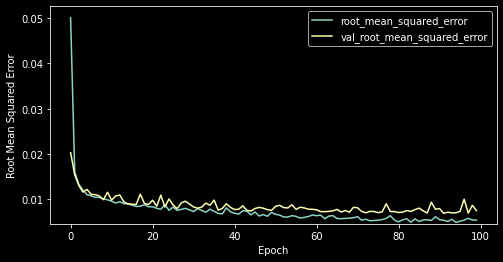

In [123]:
first_layer = train_X.shape[1]
# 0.0708 lr_model = create_model(first_layer, learn_rate=0.001, dropout=.01, dims=[154, 154], l2=1e-11)

lr_model = create_model(first_layer, learn_rate=0.001, dropout=.01, dims=[160, 160], l2=1e-11)

batch_size = 50# 5
epochs = 100 # 100

history = lr_model.fit(train_X, train_y, validation_split=0.2, epochs=epochs, verbose=2, batch_size=batch_size)
print()
scores = lr_model.evaluate(x=test_X, y=test_y, batch_size=batch_size)

# plot
plot_history(history)

In [193]:
#saved_model = lr_model.get_config()

## KFold NN


8/8 [==============================] - 0s 3ms/step - loss: 2.8041e-05 - root_mean_squared_error: 0.0053


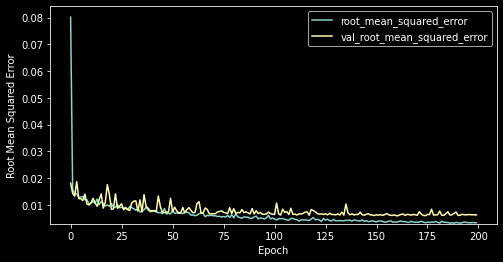


8/8 [==============================] - 0s 3ms/step - loss: 2.5168e-05 - root_mean_squared_error: 0.0050


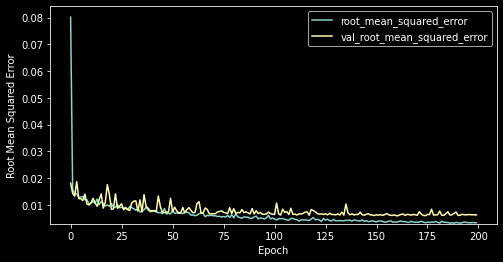


8/8 [==============================] - 0s 2ms/step - loss: 2.7467e-05 - root_mean_squared_error: 0.0052


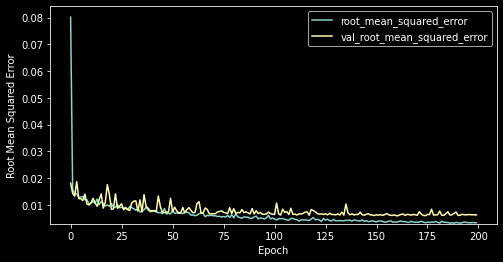


8/8 [==============================] - 0s 3ms/step - loss: 2.6090e-05 - root_mean_squared_error: 0.0051


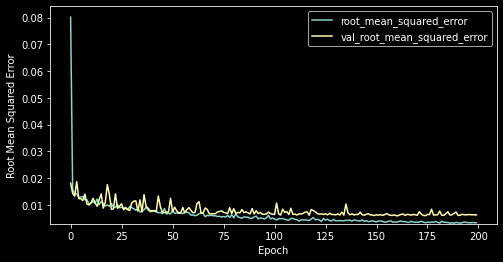


8/8 [==============================] - 0s 2ms/step - loss: 1.6080e-05 - root_mean_squared_error: 0.0040


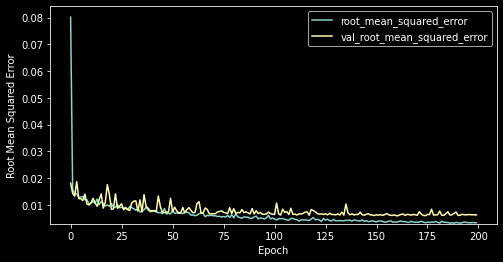


8/8 [==============================] - 0s 3ms/step - loss: 2.5109e-05 - root_mean_squared_error: 0.0050


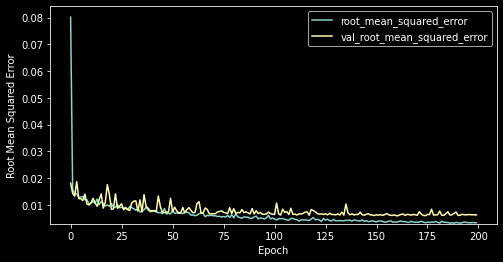


8/8 [==============================] - 0s 3ms/step - loss: 2.1520e-05 - root_mean_squared_error: 0.0046


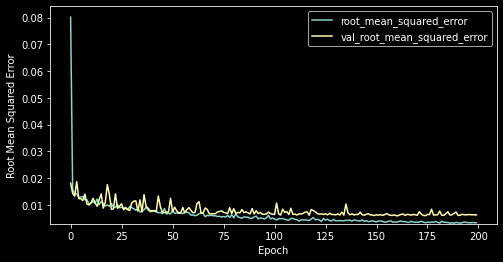


8/8 [==============================] - 0s 3ms/step - loss: 1.7395e-05 - root_mean_squared_error: 0.0042


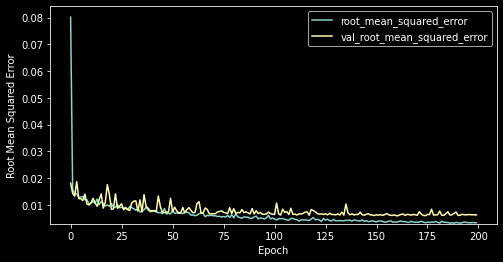


8/8 [==============================] - 0s 2ms/step - loss: 2.5037e-05 - root_mean_squared_error: 0.0050


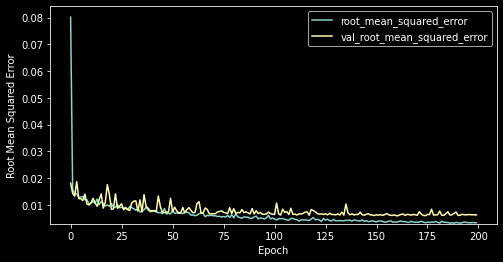


8/8 [==============================] - 0s 2ms/step - loss: 2.1658e-05 - root_mean_squared_error: 0.0047


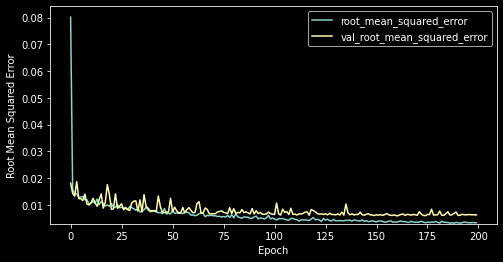

In [194]:
kfold_history = []
kfold_scores = []
kfold_models = []

kf = KFold(n_splits=10, random_state=311, shuffle=True)
for train_index, test_index in kf.split(data_wrk):
    # prepare data
    train_df, test_df = data_wrk.iloc[train_index], data_wrk.iloc[test_index]

    train_X = train_df.iloc[:,:-1]
    train_y = train_df.iloc[:,-1]

    test_X = test_df.iloc[:,:-1]
    test_y = test_df.iloc[:,-1]

    train_X = fnl.fit_transform(train_X)
    test_X = fnl.transform(test_X)

    train_y = transform_y.fit_transform(train_y)
    test_y = transform_y.transform(test_y)

    # create model
#    first_layer = train_X.shape[1]
#    lr_model = create_model(first_layer, learn_rate=0.0001, dropout=.05, dims=[80, 80], l2=1e-11)

#    batch_size=25 # 5
#    epochs=100 # 100

    kfold_history.append(lr_model.fit(train_X, train_y, validation_split=0.2, epochs=epochs, verbose=0, batch_size=batch_size))
    print()
    kfold_scores.append(lr_model.evaluate(x=test_X, y=test_y, batch_size=batch_size))
    kfold_models.append(lr_model)
    plot_history(history)

In [195]:
print(kfold_scores)
print(np.mean([x[1] for x in kfold_scores]))

[[2.8040953111485578e-05, 0.005295370705425739], [2.5168159481836483e-05, 0.00501678790897131], [2.7466541723697446e-05, 0.005240852944552898], [2.6090061510330997e-05, 0.005107843317091465], [1.6079929991974495e-05, 0.004009978845715523], [2.5109393391176127e-05, 0.005010927561670542], [2.152005436073523e-05, 0.004638971295207739], [1.7394642782164738e-05, 0.004170688334852457], [2.503692485333886e-05, 0.0050036911852657795], [2.1657964680343866e-05, 0.0046538119204342365]]
0.0048148924019187685


## NN Feature selection

In [176]:
scoresNN = dict()
for i in range(1, len(cols_corr_desc), 10):
    
    cols = cols_corr_desc[:-i]
    
    train_X = train_df.iloc[:,:-1][cols + ['galaxy', 'galactic year']]
    train_y = train_df.iloc[:,-1]

    test_X = test_df.iloc[:,:-1][cols + ['galaxy', 'galactic year']]
    test_y = test_df.iloc[:,-1]
    
    train_X = fnl.fit_transform(train_X)
    test_X = fnl.transform(test_X)

    from sklearn.utils import shuffle
    train_X, train_y = shuffle(train_X, train_y, random_state=87)

    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape);
    
    first_layer = train_X.shape[1]
    
    lr_model = create_model(first_layer, learn_rate=0.00003, dropout=0.4, dim=96, l2=1e-11)

    batch_size=50
    epochs=300

    history = lr_model.fit(train_X, train_y, validation_split=0.2, epochs=epochs, verbose=0, batch_size=batch_size)
    scores = lr_model.evaluate(x=test_X, y=test_y, batch_size=batch_size)
    
    scoresNN[i] = {#'cols': cols,
                   'history': history, 
                   'scores': scores}

# plot
#plot_history(history)

(3092, 76) (3092,) (773, 76) (773,)
16/16 [==============================] - 0s 3ms/step - loss: 2.7308e-04 - root_mean_squared_error: 0.0165
(3092, 66) (3092,) (773, 66) (773,)
16/16 [==============================] - 0s 3ms/step - loss: 2.5432e-04 - root_mean_squared_error: 0.0159
(3092, 56) (3092,) (773, 56) (773,)
16/16 [==============================] - 0s 3ms/step - loss: 2.7199e-04 - root_mean_squared_error: 0.0165
(3092, 46) (3092,) (773, 46) (773,)
16/16 [==============================] - 0s 3ms/step - loss: 4.6101e-04 - root_mean_squared_error: 0.0215
(3092, 36) (3092,) (773, 36) (773,)
16/16 [==============================] - 0s 2ms/step - loss: 5.9699e-04 - root_mean_squared_error: 0.0244
(3092, 26) (3092,) (773, 26) (773,)
16/16 [==============================] - 0s 2ms/step - loss: 6.9217e-04 - root_mean_squared_error: 0.0263
(3092, 16) (3092,) (773, 16) (773,)
16/16 [==============================] - 0s 2ms/step - loss: 7.0490e-04 - root_mean_squared_error: 0.0265
(3092,

## Ensemble NN

In [ ]:
def model_eval(train_X, train_y, test_X, test_y):
    learn_rate = 0.001
    batch_size=5
    epochs = 50
    input_dim = train_X.shape[1]

    lr_model = keras.models.Sequential()
    #model.add(tf.keras.Input(shape=(input_dim,)))
    lr_model.add(keras.layers.Dense(200, activation='relu', kernel_initializer='uniform', input_dim = input_dim,
    #                use_bias=True,
    #                kernel_regularizer=keras.regularizers.l2(1e-6),
    #                bias_regularizer=keras.regularizers.l2(1e-10),
    #                activity_regularizer=keras.regularizers.l2(1e-10)               
                                   )) 
    lr_model.add(keras.layers.Dense(200, activation='relu', kernel_initializer='uniform'))
    lr_model.add(keras.layers.Dense(1, activation='linear', kernel_initializer='uniform'))

    # compile the model
    lr_model.compile(loss='mean_squared_error', #keras.optimizers.RMSprop(lr=learn_rate),
                  optimizer=keras.optimizers.RMSprop(lr=learn_rate),
                  metrics=[keras.metrics.RootMeanSquaredError()])
 
    history = lr_model.fit(train_X, train_y, epochs=epochs, verbose=2, batch_size=batch_size)
    score = lr_model.evaluate(x=test_X, y=test_y, batch_size=batch_size)
    return lr_model, score

In [ ]:
# cross validation estimation of performance
n_folds = 10
kfold = KFold(n_folds, True, 1)
scores, members = list(), list()
for train_ix, test_ix in kfold.split(data_wrk):
	# select samples
	train_X, train_y = X[train_ix], y[train_ix]
	test_X, test_y = X[test_ix], y[test_ix]
	# evaluate model
	model, test_acc = evaluate_model(train_X, train_y, test_X, test_y)
	print('>%.3f' % test_acc)
	scores.append(test_acc)
	members.append(model)

# Predict

In [121]:
# data for fit
train_X = data_train.iloc[:,:-1]
train_y = data_train.iloc[:,[-1]]

train_X = fnl.fit_transform(train_X)
train_y = transform_y.fit_transform(train_y)

#lr_model.fit(train_X, train_y, epochs=epochs, verbose=0, batch_size=batch_size)

pred_X = data_test.sort_index().reset_index(drop=True).copy()

pred_X = fnl.transform(pred_X)
pred_y = lr_model.predict(pred_X)
pred_y = transform_y.inverse_transform(pred_y)
pred_y.max(), pred_y.min()

(0.36658537, 0.019999813)

In [200]:
data_all_final = pd.concat([data_train, data_test.join(pd.DataFrame(pred_y, columns=['y']))], keys=['train', 'test'])
data_all_final.sort_values(by='y', ascending=False).iloc[:20].transpose()


train               \
                                                           3603         3731   
galactic year                                           1013042      1014049   
galaxy                                              Cetus Dwarf  Cetus Dwarf   
existence expectancy index                                 1.12         1.13   
existence expectancy at birth                             88.28        87.22   
Gross income per capita                               56,524.76    55,587.40   
Income Index                                               1.12         1.13   
Expected years of education (galactic years)              23.21        23.49   
Mean years of education (galactic years)                  16.98        16.24   
Intergalactic Development Index (IDI)                      1.06         1.06   
Education Index                                            1.11         1.27   
Intergalactic Development Index (IDI), Rank               39.04        85.59   
Population using at least basic drinking-water ...       116.31       119.84   
Population using at least basic sanitation serv...       152.88       132.35   
Gross capital formation (% of GGP)                        23.14        24.18   
Population, total (millions)                             366.35       481.42   
Population, urban (%)                                    110.87       109.73   
Mortality rate, under-five (per 1,000 live births)        36.20        58.79   
Mortality rate, infant (per 1,000 live births)            15.31        31.64   
Old age dependency ratio (old age (65 and older...        27.07        25.41   
Population, ages 15–64 (millions)                        430.79       366.25   
Population, ages 65 and older (millions)                  59.78        41.01   
Life expectancy at birth, male (galactic years)           93.55        89.69   
Life expectancy at birth, female (galactic years)         94.39        91.80   
Population, under age 5 (millions)                        55.06        59.52   
Young age (0-14) dependency ratio (per 100 crea...        54.41        57.82   
Adolescent birth rate (births per 1,000 female ...        54.40        63.60   
Total unemployment rate (female to male ratio)             2.30         2.50   
Vulnerable employment (% of total employment)             28.43        24.41   
Unemployment, total (% of labour force)                   14.90        11.43   
Employment in agriculture (% of total employment)         17.43        24.55   
Labour force participation rate (% ages 15 and ...        82.93        89.80   
Labour force participation rate (% ages 15 and ...        83.48        92.06   
Employment in services (% of total employment)           101.88        86.75   
Labour force participation rate (% ages 15 and ...        89.41        84.47   
Employment to population ratio (% ages 15 and o...        82.24        78.34   
Jungle area (% of total land area)                        24.18        19.42   
Share of employment in nonagriculture, female (...        59.23        59.87   
Youth unemployment rate (female to male ratio)             1.18         1.23   
Unemployment, youth (% ages 15–24)                        24.59        23.45   
Mortality rate, female grown up (per 1,000 people)       130.47       135.04   
Mortality rate, male grown up (per 1,000 people)         134.31       239.69   
Infants lacking immunization, red hot disease (...        22.91        21.69   
Infants lacking immunization, Combination Vacci...        14.09        16.45   
Gross galactic product (GGP) per capita               56,938.99    58,222.30   
Gross galactic product (GGP), total                    6,763.73     7,708.59   
Outer Galaxies direct investment, net inflows (...        20.57        19.23   
Exports and imports (% of GGP)                           143.83       149.31   
Share of seats in senate (% held by female)               49.45        51.45   
Natural resource depletion                                

# Energy split

In [254]:
from scipy.optimize import Bounds, LinearConstraint, minimize, HessianUpdateStrategy
import numpy as np
import pandas as pd

pred = pred_y.reshape(1,-1)[0]
sz = len(pred)

def func_en(En):
    #print(-sum(En * ((-np.log(pred + 0.01) + 3) ** 2 / 1000)))
    return -sum(En * ((-np.log(pred + 0.01) + 3) ** 2 / 1000))

bounds = Bounds(0, 1)
linear_constraint = LinearConstraint([np.array(data_test['existence expectancy index'] < 0.7).astype('float'),
                                      np.ones(sz)], [50, 0], [np.inf, 500])

En0 = np.random.random(sz);
res = minimize(func_en, En0, method='trust-constr', jac='2-point', \
                   constraints=[linear_constraint], \
                   options={'verbose': 1}, bounds=bounds)


`gtol` termination condition is satisfied.
Number of iterations: 28, function evaluations: 17820, CG iterations: 23, optimality: 2.70e-09, constraint violation: 0.00e+00, execution time: 1.2e+02 s.


In [255]:
res.fun
#16.84650144962803
#17.935576687882783

-18.358529002312228

In [298]:
from scipy.optimize import basinhopping
minimizer_kwargs = {"method":"trust-constr", "jac":'2-point', 'constraints':[linear_constraint], 'bounds': bounds}
En0 = np.random.random(sz);
ret = basinhopping(func_en, En0, minimizer_kwargs=minimizer_kwargs,
                    niter=10)

In [302]:
ret.fun
#-16.84617913608769
ret

                        fun: -16.846501282848386
 lowest_optimization_result:  barrier_parameter: 2.560000000000001e-07
 barrier_tolerance: 2.560000000000001e-07
          cg_niter: 23
      cg_stop_cond: 4
            constr: [array([ 50.00007353, 499.99999161]), array([9.99923885e-01, 9.99940382e-01, 9.99943425e-01, 9.99932671e-01,
       9.99937809e-01, 9.99953940e-01, 9.99932770e-01, 9.99921235e-01,
       9.99764704e-01, 9.99937763e-01, 9.99924365e-01, 9.99963653e-01,
       9.99912657e-01, 9.99919249e-01, 9.99968249e-01, 9.99936995e-01,
       9.99942629e-01, 9.99898497e-01, 9.99936097e-01, 9.99925568e-01,
       9.99949585e-01, 9.99937924e-01, 9.99891650e-01, 9.99960859e-01,
       9.99887131e-01, 9.99941066e-01, 9.99940737e-01, 9.99948264e-01,
       9.99908332e-01, 9.99936901e-01, 9.99909747e-01, 9.99944688e-01,
       9.99915933e-01, 9.99903040e-01, 9.99937136e-01, 9.99924898e-01,
       9.99775573e-01, 9.99946106e-01, 9.99949898e-01, 9.99941559e-01,
       9.99889472e-01, 9.

In [358]:
[(0,1)] * 3

[(0, 1), (0, 1), (0, 1)]

In [360]:
from scipy import optimize

dif_evo = optimize.differential_evolution(func_en, [(0,1)] * len(pred), constraints=[linear_constraint], maxiter=10)
#opts.append(optimize.shgo(func_en, bounds, constraints=[linear_constraint]))

In [635]:
print(max(res.x * 100), sum(res.x * 100), sum(res.x[data_test['existence expectancy index'] < 0.7] * 100))

99.99797683138067 49999.99920905408 5000.006626897888


# Prepare submit

In [256]:

data_submit = pd.DataFrame()
data_submit['pred'] = pred
data_submit['opt_pred'] = res.x * 100
data_submit.reset_index().to_csv('submit.csv', index=False, float_format='%.8f')

In [193]:
(pd.concat([pd.read_csv('submit.csv')['opt_pred'], pd.Series(res.x*100)], axis=1)).sum()

opt_pred   50,000.00
0          50,000.00
dtype: float64